# Observed mutations (training cohort) overview

Observed mutations from the three training cohorts

This notebook contains the code to generate the plots:

    1- Figure 1B ; DNMT3A nedlaplots including positive set (training set) and negative set (neutral mutagenesis).
    2- Supplemental Figure S3. Needleplots of the observed mutations from the 12 genes.  
    3- Supplemental Figure S8B. Mutational patterns from the three training cohorts.

## Upload dependencies from scripts

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import sys

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import collections as mc
from matplotlib import gridspec

pd.options.display.max_columns = 60

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
import warnings
warnings.filterwarnings('ignore')

In [4]:
output_boostdm = '/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality'

# Upload mutations
def get_mutations():
    obs_mut = pd.read_csv(os.path.join(output_boostdm, 'discovery', 'mutations.tsv'), sep='\t')
    obs_mut.rename(columns={'mut': 'alt'}, inplace=True)
    obs_mut['chr'] = obs_mut['chr'].astype(str)
    obs_mut['pos'] = obs_mut['pos'].astype(int)
    return obs_mut

# Get observed mutations (training set)
obs_muts = get_mutations()
print(len(obs_muts))
obs_muts.columns

438010


Index(['sampleID', 'chr', 'pos', 'ref', 'alt', 'gene', 'strand', 'ref_cod',
       'mut_cod', 'ref3_cod', 'mut3_cod', 'aachange', 'ntchange', 'codonsub',
       'impact', 'pid', 'COHORT'],
      dtype='object')

In [6]:
# List all the prediction outputs from BoostDM-CH
prediction_paths = list(glob.glob(os.path.join('../../Paper_data/BoostDM-CH/prediction/', 
                                               '*.*.prediction.tsv.gz')))
prediction_paths[0]

'../../Paper_data/BoostDM-CH/prediction/IDH2.CH.prediction.tsv.gz'

## 1. Figure 1B

DNMT3A nedlaplots including positive set (training set) and negative set (neutral mutagenesis)

In [7]:
## Upload dependencies and functions

PFAM_files = os.path.join('../../Paper_data/pfam/pfam_biomart.tsv.gz')
PFAM_info = os.path.join('../../Paper_data/pfam/pfam_names.info.csv')
# CDS coordinates
path_coord = os.path.join('../../Paper_data/pfam/cds_biomart.tsv')


def get_position(row):

    try:
        v = int("".join(row["aachange"][1:-1]))
        return v
    except:
        return -1
    
def get_PFAMs_per_transcript(PFAM_files, PFAM_info, transcript):
    df_pfam = pd.read_csv(PFAM_files, sep="\t", names=["ENSEMBL_GENE", "ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"])
    df_names = pd.read_csv(PFAM_info, sep="\t", names=["DOMAIN", "CLAN", "CLAN_NAME", "DOMAIN_NAME", "Long Name"])

    # Get domains
    df_pfam_gene = df_pfam[(df_pfam["ENSEMBL_TRANSCRIPT"] == transcript)]
    df_pfam_gene = df_pfam_gene[["ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"]].drop_duplicates()
    df_pfam_gene = pd.merge(df_pfam_gene, df_names[["DOMAIN", "DOMAIN_NAME"]].drop_duplicates(), how="left")
    df_pfam_gene["POS"] = df_pfam_gene.apply(lambda row: row["START"] + ((row["END"] - row["START"]) // 2), axis=1)
    df_pfam_gene["SIZE"] = df_pfam_gene.apply(lambda row: row["END"] - row["START"] + 1, axis=1)
    df_pfam_gene["Color"] = "#998ec3"

    return df_pfam_gene


def get_positions_in_CDS(transcript, path_coord):
    df = pd.read_csv(path_coord, sep='\t', low_memory=False,
                     names=['gene', 'gene_symbol', 'prot', 'chr', 's', 'e', 'aa', 'cds', 'genpos',
                            'strand', 'transcript'])

    toappend = []
    strand = ''
    for i, row in df[df['transcript'] == transcript].sort_values(by='s').iterrows():
        toappend.extend([i for i in range(row['s'], row['e'] + 1)])
        strand = row['strand']
    if strand == -1:
        toappend = toappend[::-1]

    return toappend


def plot_gene_full_nucleotide(subset_data_pfam, df, transcript, path_coord,
                              ax0, ax1, trainer):

    # remove those mutations not falling in CDS:
    df = df[df['AA'] != 'n']

    # Configure the axis
    ax0.set_title('Observed mutations')
    ax0.set_ylabel("mutation count")

    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_linewidth(1)
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.tick_params(axis='y', labelsize=6, pad=0.25, width=0.25, length=1.5)
    ax1.tick_params(axis='x', length=0)
    ax1.set_yticks([])
    ax0.set_xticks([])

    # set equivalent coordinates for the three possible mutations
    set_coordinates = get_positions_in_CDS(transcript, path_coord)

    # we need to get the set of equivalent coordinates per gene
    equivalent_coordinates = {coord: i for i, coord in enumerate(set_coordinates)}
    vals_coord = list(equivalent_coordinates.values())
    axs = [ax0]
    for ax in axs:
        ax.set_xlim(np.min(vals_coord), np.max(vals_coord))

    # plot observed mutations
    pos_list = df["pos"].tolist()
    ys = df["number_observed_muts"].values


    coordinates_mutations = []

    passenger_x = []
    passenger_y = []
    passenger_color = []

    driver_x = []
    driver_y = []
    driver_color = []

    # for each of the positions
    for i, p in enumerate(pos_list):
        if ys[i] > 0:

            coordinates_mutations.append([(equivalent_coordinates[p], 0),
                                          (equivalent_coordinates[p], ys[i] - 0.1)])

            driver_x.append(equivalent_coordinates[p])
            driver_y.append(ys[i])

            if trainer == 'simulated':
                driver_color.append('grey')
            elif trainer == 'trainer':
                driver_color.append('#ac0f0f')

    lc = mc.LineCollection(coordinates_mutations, colors='black', linewidths=1, alpha=0.3)
    ax0.add_collection(lc)

    size = 12
    ax0.scatter(driver_x, driver_y, s=size, c=driver_color, alpha=0.7)
    
#     leg = ax0.legend()
#     leg.get_frame().set_linewidth(0.0)

    ax1.set_ylim(0, 1)

    for i, r in subset_data_pfam.iterrows():
        start_base = 3 * r['START']
        size_base = 3 * r['SIZE']
        rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
        ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=7)
        ax1.add_patch(rect)
        
def needle_plot(data, gene, transcript):
    config_params(font_size=6)

    mpl.rcParams['figure.dpi']= 200

    # get PFAM domains and subset the mutation data
    subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, transcript)

    # define figure layout
    fig = plt.figure(figsize=(8, 2.25))
    # ! SDM change
    gs = gridspec.GridSpec(11, 3, figure=fig)
    ax1 = plt.subplot(gs[1:-1, :2])
    ax2 = plt.subplot(gs[-1, :2], sharex=ax1)
    
    # plot for each axes
    plot_gene_full_nucleotide(subset_data_pfam, data, transcript, path_coord, ax1, ax2, 'trainer')
    ax2.set_xlabel('CDS base position')
    plt.show()

In [8]:
# Upload training and simulated data from the three cohorts
create_datasets_path = '/workspace/projects/boostdm_ch/output/run_20220705/create_datasets/'
HMF_dataset = pd.read_csv(create_datasets_path+'OTHER_WGS_HMF_FULL.regression_data.tsv', sep='\t')
MSKCC_dataset = pd.read_csv(create_datasets_path+'OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv', sep='\t')
TCGA_dataset = pd.read_csv(create_datasets_path+'OTHER_WXS_TCGA_FULL.regression_data.tsv', sep='\t')

# Join the three datasets
ALL_dataset = pd.concat([HMF_dataset, MSKCC_dataset, TCGA_dataset], axis=0)
print(len(ALL_dataset))

# Restrict datasets to DNMT3A mutaitons
ALL_dataset_DNMT3A_training = ALL_dataset[(ALL_dataset['gene']=='DNMT3A') & (ALL_dataset['response']==1)]
ALL_dataset_DNMT3A_simulated = ALL_dataset[(ALL_dataset['gene']=='DNMT3A') & (ALL_dataset['response']==0)]

279837


### Trainning set

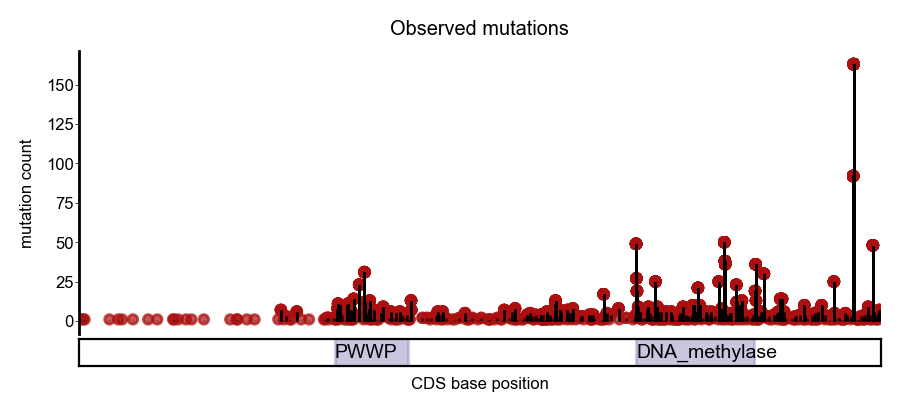

In [9]:
# TRAINING SET PLOT
ALL_dataset_DNMT3A_training['chr'] = ALL_dataset_DNMT3A_training['chr'].astype(str)
ALL_dataset_DNMT3A_training['pos'] = ALL_dataset_DNMT3A_training['pos'].astype(int)
ALL_dataset_DNMT3A_training = ALL_dataset_DNMT3A_training[ALL_dataset_DNMT3A_training['aachange'].notna()]
ALL_dataset_DNMT3A_training["Protein_position"] = ALL_dataset_DNMT3A_training.apply(lambda row: get_position(row), axis=1)
ALL_dataset_DNMT3A_training["AA"] = ALL_dataset_DNMT3A_training.apply(lambda row: row["aachange"][0], axis=1)
ALL_dataset_DNMT3A_training['ID'] = ALL_dataset_DNMT3A_training.apply(lambda x: '{}_{}'.format(x['pos'], x['alt']), axis=1)

df_counts = ALL_dataset_DNMT3A_training.groupby(["pos"], as_index=False).agg({"ID": "count"})
df_counts.rename(columns={"ID": "number_observed_muts"}, inplace=True)
data = ALL_dataset_DNMT3A_training.merge(df_counts, how='left')
needle_plot(data, 'DNMT3A', 'ENST00000264709')

In [19]:
# SIMULATED SET PLOT
ALL_dataset_DNMT3A_simulated['chr'] = ALL_dataset_DNMT3A_simulated['chr'].astype(str)
ALL_dataset_DNMT3A_simulated['pos'] = ALL_dataset_DNMT3A_simulated['pos'].astype(int)
ALL_dataset_DNMT3A_simulated = ALL_dataset_DNMT3A_simulated[ALL_dataset_DNMT3A_simulated['aachange'].notna()]
ALL_dataset_DNMT3A_simulated["Protein_position"] = ALL_dataset_DNMT3A_simulated.apply(lambda row: get_position(row), axis=1)
ALL_dataset_DNMT3A_simulated["AA"] = ALL_dataset_DNMT3A_simulated.apply(lambda row: row["aachange"][0], axis=1)
ALL_dataset_DNMT3A_simulated['ID'] = ALL_dataset_DNMT3A_simulated.apply(lambda x: '{}_{}'.format(x['pos'], x['alt']), axis=1)
ALL_dataset_DNMT3A_simulated = ALL_dataset_DNMT3A_simulated.sample(n = len(ALL_dataset_DNMT3A_training))

df_counts = ALL_dataset_DNMT3A_simulated.groupby(["pos"], as_index=False).agg({"ID": "count"})
df_counts.rename(columns={"ID": "number_observed_muts"}, inplace=True)
data = ALL_dataset_DNMT3A_simulated.merge(df_counts, how='left')

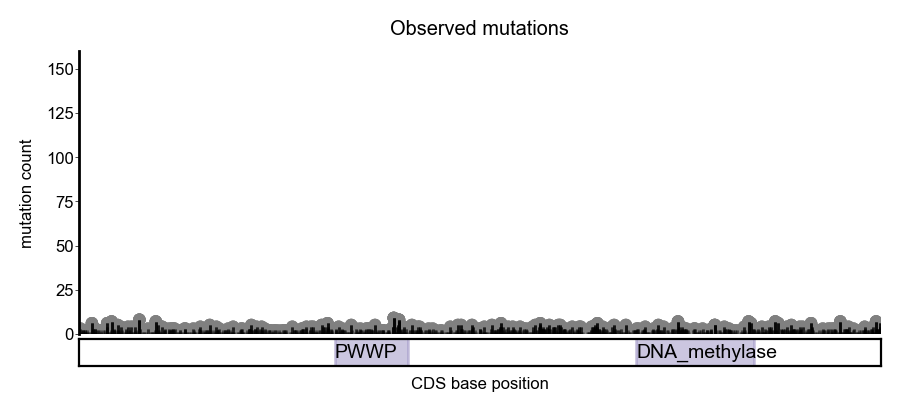

In [23]:
config_params(font_size=6)
    
mpl.rcParams['figure.dpi']= 200

# get PFAM domains and subset the mutation data
subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, 'ENST00000264709')

# define figure layout
fig = plt.figure(figsize=(8, 2.25))
gs = gridspec.GridSpec(11, 3, figure=fig)
ax1 = plt.subplot(gs[1:-1, :2])
ax2 = plt.subplot(gs[-1, :2], sharex=ax1)
ax1.set_yticks((0, 25, 50, 75, 100, 125, 150))
ax1.set_ylim(0, 160)
# plot for each axes
plot_gene_full_nucleotide(subset_data_pfam, data, 'ENST00000264709', path_coord, ax1, ax2, 'simulated')
ax2.set_xlabel('CDS base position')
plt.show()

## 2. Supplementary Figure 5

Needleplots of the observed mutations (training sets) from the 12 high quality models

In [24]:
## Upload dependencies and functions

def get_plot_data_joanen(data):

    data["Protein_position"] = data.apply(lambda row: get_position(row), axis=1)
    data["AA"] = data.apply(lambda row: row["aachange"][0], axis=1)
    data['ID'] = data.apply(lambda x: '{}_{}'.format(x['pos'], x['alt']), axis=1)

    score_values = data['boostDM_score'].tolist()
    count_driver_unique = len(set(data[data['boostDM_class']]['ID']))  # predicted to be drivers (unique)
    count_driver = len(data[data['boostDM_class']]['ID'])  # predicted to be drivers
    count_total = len(data['ID'])  # total number of mutations
    count_total_unique = len(set(data['ID']))  # total mutations (unique)
    data = data.groupby(["ID", "pos", "AA", "Protein_position", "gene", "ENSEMBL_TRANSCRIPT", "boostDM_score", "boostDM_class"], as_index=False).agg({"sampleID": "count"})
    data.rename(columns={"sampleID": "number_observed_muts"}, inplace=True)

    return data, count_driver, count_driver_unique, count_total, count_total_unique, score_values


def create_observed_dataset(prediction_path, gene, cohort, obs_mut):

    sat_pred = pd.read_csv(prediction_path, sep='\t')
    sat_pred['chr'] = sat_pred['chr'].astype(str)
    sat_pred['pos'] = sat_pred['pos'].astype(int)
    # ! SDM CHANGE
    # Original: obs_mut = obs_mut[(obs_mut['gene'] == gene) & (obs_mut['COHORT'] == cohort)]
    obs_mut = obs_mut[obs_mut['gene'] == gene]
    df = obs_mut.merge(sat_pred, on=['gene', 'chr', 'pos', 'alt', 'aachange'], how='left')
    df.rename(columns={"COHORT": "cancer_type"}, inplace=True)
    df = df[~df['boostDM_class'].isnull()]
    return df


def plot_score_distribution(values, ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

    n, bins, patches = ax.hist(values, bins=20, orientation='vertical')
    for i in range(2):
        patches[i].set_facecolor('grey')
    for i in range(2, 10):
        patches[i].set_facecolor('grey')
    for i in range(10, 18):
        patches[i].set_facecolor('#B65555')
    for i in range(18, 20):
        patches[i].set_facecolor('#950A0A')
#     ax.axvline(x=0.1,linestyle='--', linewidth=0.2, color='k')
    ax.axvline(x=0.5,linestyle='--', linewidth=0.2, color='k')
    ax.axvline(x=0.9,linestyle='--', linewidth=0.2, color='k')
    ax.set_xlim(0, 1)


def get_plot_data_tiers(data):

    data["Protein_position"] = data.apply(lambda row: get_position(row), axis=1)
    data["AA"] = data.apply(lambda row: row["aachange"][0], axis=1)
    data['ID'] = data.apply(lambda x: '{}_{}'.format(x['pos'], x['alt']), axis=1)

    score_values = data['boostDM_score'].tolist()
    count_high_driver_unique = len(set(data[data['boostDM_score']>=0.9]['ID']))  # predicted to be drivers (unique)
    count_high_driver = len(data[data['boostDM_score']>=0.9]['ID'])  # predicted to be drivers
    
    count_other_driver_unique = len(set(data[(data['boostDM_score']>=0.5)&(data['boostDM_score']<0.9)]['ID']))  # predicted to be drivers (unique)
    count_other_driver = len(data[(data['boostDM_score']>=0.5)&(data['boostDM_score']<0.9)]['ID'])  # predicted to be drivers
    
    count_high_non_driver_unique = len(set(data[data['boostDM_score']<0.1]['ID']))  # predicted to be drivers (unique)
    count_high_non_driver = len(data[data['boostDM_score']<0.1]['ID'])  # predicted to be drivers
    
    count_other_non_driver_unique = len(set(data[(data['boostDM_score']>=0.1)&(data['boostDM_score']<0.5)]['ID']))  # predicted to be drivers (unique)
    count_other_non_driver = len(data[(data['boostDM_score']>=0.1)&(data['boostDM_score']<0.5)]['ID'])  # predicted to be driver
    
    count_total = len(data['ID'])  # total number of mutations
    count_total_unique = len(set(data['ID']))  # total mutations (unique)
    #We excluded the cancer_type in the operation of gruping because otherwise we were separating mutations in terms of the cohort.
    data = data.groupby(["ID", "pos", "AA", "Protein_position", "gene", "ENSEMBL_TRANSCRIPT", "boostDM_score", "boostDM_class"], as_index=False).agg({"sampleID": "count"})
    data.rename(columns={"sampleID": "number_observed_muts"}, inplace=True)

    return data, count_high_driver_unique, count_high_driver, count_other_driver_unique, count_other_driver, count_high_non_driver_unique, count_high_non_driver, count_other_non_driver_unique, count_other_non_driver, count_total, count_total_unique, score_values


def plot_observed_distribution(gene, ttype, model, sat_pred, data, count_high_driver_unique, count_high_driver, count_other_driver_unique, count_other_driver, count_high_non_driver_unique, count_high_non_driver, count_other_non_driver_unique, count_other_non_driver, count_total, count_total_unique, score_values, dpi=300, plotfile=None):

    config_params(font_size=6)
    mpl.rcParams['figure.dpi']= dpi
    wanted_df = data[data['gene'] == gene]
    for transcript, gene in wanted_df[["ENSEMBL_TRANSCRIPT",
                                              "gene"]].drop_duplicates().values:

        # get PFAM domains and subset the mutation data
        subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, transcript)
        subset_data_muts = data[data["ENSEMBL_TRANSCRIPT"] == transcript]

        # define figure layout
        fig = plt.figure(figsize=(8, 2.25))
        # ! SDM change
        # fig.suptitle(f'gene={gene};\ncohort={ttype};\n model={model}', y=1.1)
        fig.suptitle(f'gene={gene}', y=1.1)
        gs = gridspec.GridSpec(11, 3, figure=fig)
        ax1 = plt.subplot(gs[1:-1, :2])
        ax2 = plt.subplot(gs[-1, :2])
        ax3 = plt.subplot(gs[0:4, 2])
        ax4 = plt.subplot(gs[7:9, 2])
        ax5 = plt.subplot(gs[9:, 2])

        # plot for each axes
        plot_score_distribution(score_values, ax3)
        plot_barplot_drivers(count_high_driver_unique, count_other_driver_unique, count_high_non_driver_unique, count_other_non_driver_unique, count_total_unique, ax5)
        plot_barplot_drivers_nonunique(count_high_driver, count_other_driver, count_high_non_driver, count_other_non_driver, count_total, ax4)
        plot_gene_full_nucleotide(subset_data_pfam, subset_data_muts, transcript, sat_pred, path_coord, ax1, ax2)

        ax3.set_xlabel('boostDM-CH score')
        ax5.spines['bottom'].set_sketch_params(length=1)
        ax5.set_xlabel('mutation proportion')
        ax2.set_xlabel('CDS base position')

        if plotfile is not None:
            plt.savefig(plotfile + '.svg', dpi=300, bbox_inches='tight')
            plt.savefig(plotfile + '.png', dpi=300, bbox_inches='tight')
            
        plt.show()
        
        
def plot_gene_full_nucleotide(subset_data_pfam, df, transcript, sat_pred, path_coord,
                              ax0, ax1, all_possible=False):

    # remove those mutations not falling in CDS:
    df = df[df['AA'] != 'n']

    # Configure the axis
    ax0.set_title(f'Observed mutations (n={df["number_observed_muts"].sum():,})')
    ax0.set_ylabel("mutation count")

    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_linewidth(1)
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.tick_params(axis='y', labelsize=6, pad=0.25, width=0.25, length=1.5)
    ax0.tick_params(axis='x', length=0)
    ax0.set_xticks([])
    ax1.set_yticks([])

    # set equivalent coordinates for the three possible mutations
    set_coordinates = get_positions_in_CDS(transcript, path_coord)


    # we need to get the set of equivalent coordinates per gene
    equivalent_coordinates = {coord: i for i, coord in enumerate(set_coordinates)}
    vals_coord = list(equivalent_coordinates.values())
    axs = [ax0]
    for ax in axs:
        ax.set_xlim(np.min(vals_coord), np.max(vals_coord))

    # plot observed mutations
    pos_list = df["pos"].tolist()
    ys = df["number_observed_muts"].values

    d = df["boostDM_score"].values

    coordinates_mutations = []

    passenger_x = []
    passenger_y = []
    passenger_color = []

    driver_x = []
    driver_y = []
    driver_color = []

    # for each of the positions
    for i, p in enumerate(pos_list):
        if ys[i] > 0:

            coordinates_mutations.append([(equivalent_coordinates[p], 0),
                                          (equivalent_coordinates[p], ys[i] - 0.1)])

            if d[i] < 0.5:

                passenger_x.append(equivalent_coordinates[p])
                if all_possible:
                    passenger_y.append(d[i])
                else:
                    passenger_y.append(ys[i])
                passenger_color.append('#636363')

            else:
                driver_x.append(equivalent_coordinates[p])
                if all_possible:
                    driver_y.append(d[i])
                else:
                    driver_y.append(ys[i])
                driver_color.append('#ac0f0f')

    lc = mc.LineCollection(coordinates_mutations, colors='black', linewidths=1, alpha=0.3)
    ax0.add_collection(lc)

    size = 12
    ax0.scatter(passenger_x, passenger_y, s=size, c=passenger_color, alpha=0.7, label='non-driver')
    ax0.scatter(driver_x, driver_y, s=size, c=driver_color, alpha=0.7, label='driver')

    leg = ax0.legend()
    leg.get_frame().set_linewidth(0.0)

    ax1.set_ylim(0, 1)

    for i, r in subset_data_pfam.iterrows():
        start_base = r['START']
        size_base = r['SIZE']
        rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
        ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=7)
        ax1.add_patch(rect)

    ax1.set_xticks(np.append(np.arange(0, max(sat_pred['Protein_position']), 100)[:-1], max(sat_pred['Protein_position'])))
    ax1.set_xticklabels(np.append(np.arange(0, max(sat_pred['Protein_position']), 100)[:-1], max(sat_pred['Protein_position'])), fontsize = 6)
    ax1.set_xlim(2, max(sat_pred['Protein_position']))        
        
        
def plot_barplot_drivers(count_high_driver_unique, count_other_driver_unique, count_high_non_driver_unique, count_other_non_driver_unique, count_total_unique, ax):

    nondriver_frac =  (count_high_non_driver_unique+count_other_non_driver_unique) / count_total_unique
    driver_high_frac = count_high_driver_unique / count_total_unique
    driver_other_frac = count_other_driver_unique / count_total_unique

    ax.barh(0, nondriver_frac, height=0.3, color='grey', left=0)
    ax.barh(0, driver_other_frac, height=0.3, left=nondriver_frac, color='#B65555')
    ax.barh(0, driver_high_frac, height=0.3, left=driver_other_frac+nondriver_frac, color='#950A0A')
#     ax.barh(0, driver_high_frac, height=0.3, left=driver_other_frac+nondriver_other_frac+nondriver_high_frac, color='#950A0A', alpha=0.5)
    ax.text(nondriver_frac/3, 0, f'{float(count_high_non_driver_unique+count_other_non_driver_unique):,.0f}')
    if count_other_driver_unique > 0:
        ax.text(nondriver_frac+ (driver_other_frac/3), 0, f'{count_other_driver_unique:,}')
    ax.text((nondriver_frac+driver_other_frac) + (driver_high_frac/3), 0, f'{count_high_driver_unique:,}', color='white')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('unique', rotation=0, labelpad=18)


def plot_barplot_drivers_nonunique(count_high_driver, count_other_driver, count_high_non_driver, count_other_non_driver, count_total, ax):

    nondriver_frac =  (count_high_non_driver+count_other_non_driver) / count_total
    driver_high_frac = count_high_driver / count_total
    driver_other_frac = count_other_driver / count_total
    
    
    ax.barh(0, nondriver_frac, height=0.3, color='grey', left=0)
    ax.barh(0, driver_other_frac, height=0.3, left=nondriver_frac, color='#B65555')
    ax.barh(0, driver_high_frac, height=0.3, left=driver_other_frac+nondriver_frac, color='#950A0A')
       
    ax.text(nondriver_frac/4, 0, f'{float(count_high_non_driver+count_other_non_driver):,.0f}')
    if count_other_driver > 0:
        ax.text(nondriver_frac+ (driver_other_frac/3), 0, f'{count_other_driver:,}')
    ax.text((nondriver_frac+driver_other_frac) + (driver_high_frac/3), 0, f'{count_high_driver:,}', color='white')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0, 1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('all observed', rotation=0, labelpad=25)        
        
        
def needleplot(gene):
    # Change: take only gene and model (CH)
    fn = [x for x in prediction_paths if gene in x][0]
    gene, model = tuple((gene, 'CH'))
    sat_pred = pd.read_csv(fn, sep='\t')
    sat_pred["Protein_position"] = sat_pred.apply(lambda row: get_position(row), axis=1)
    # Change: change 'cohort' by 'model'
    df = create_observed_dataset(fn, gene, model, obs_muts)
    args = get_plot_data_tiers(df)
    # Change: change 'cohort' by 'model' (2 'model')
    plot_observed_distribution(gene, model, model, sat_pred, *args)

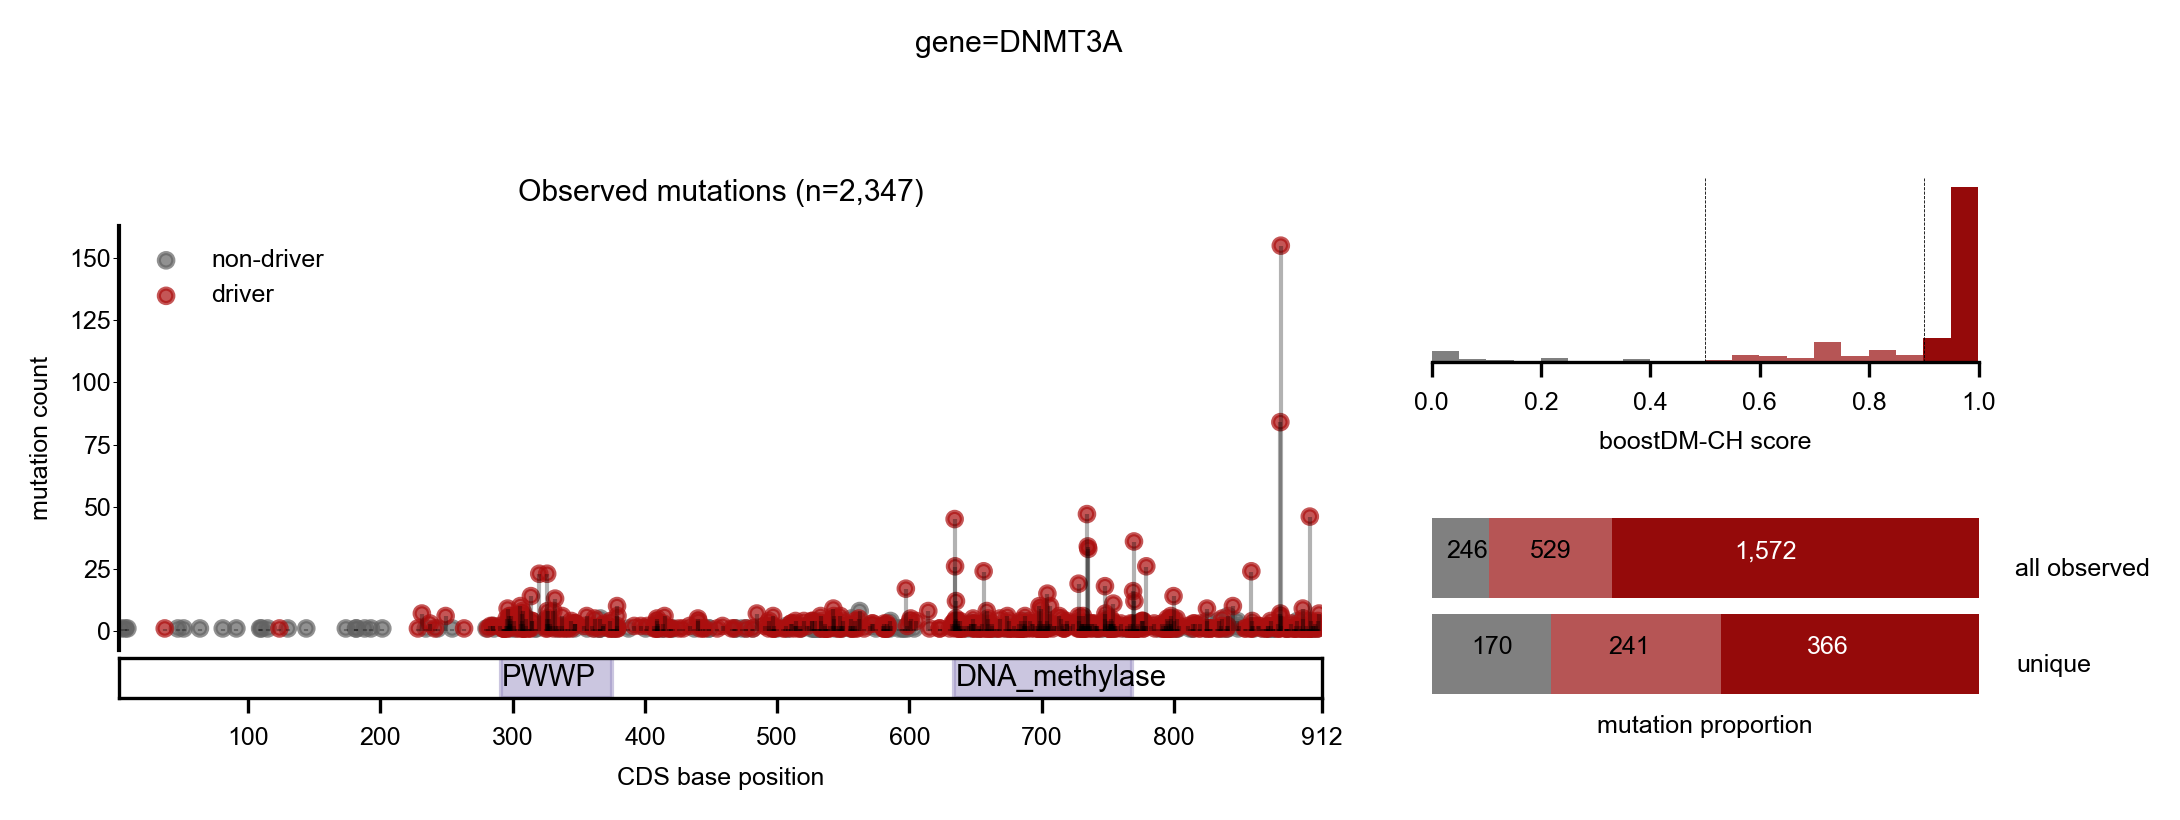

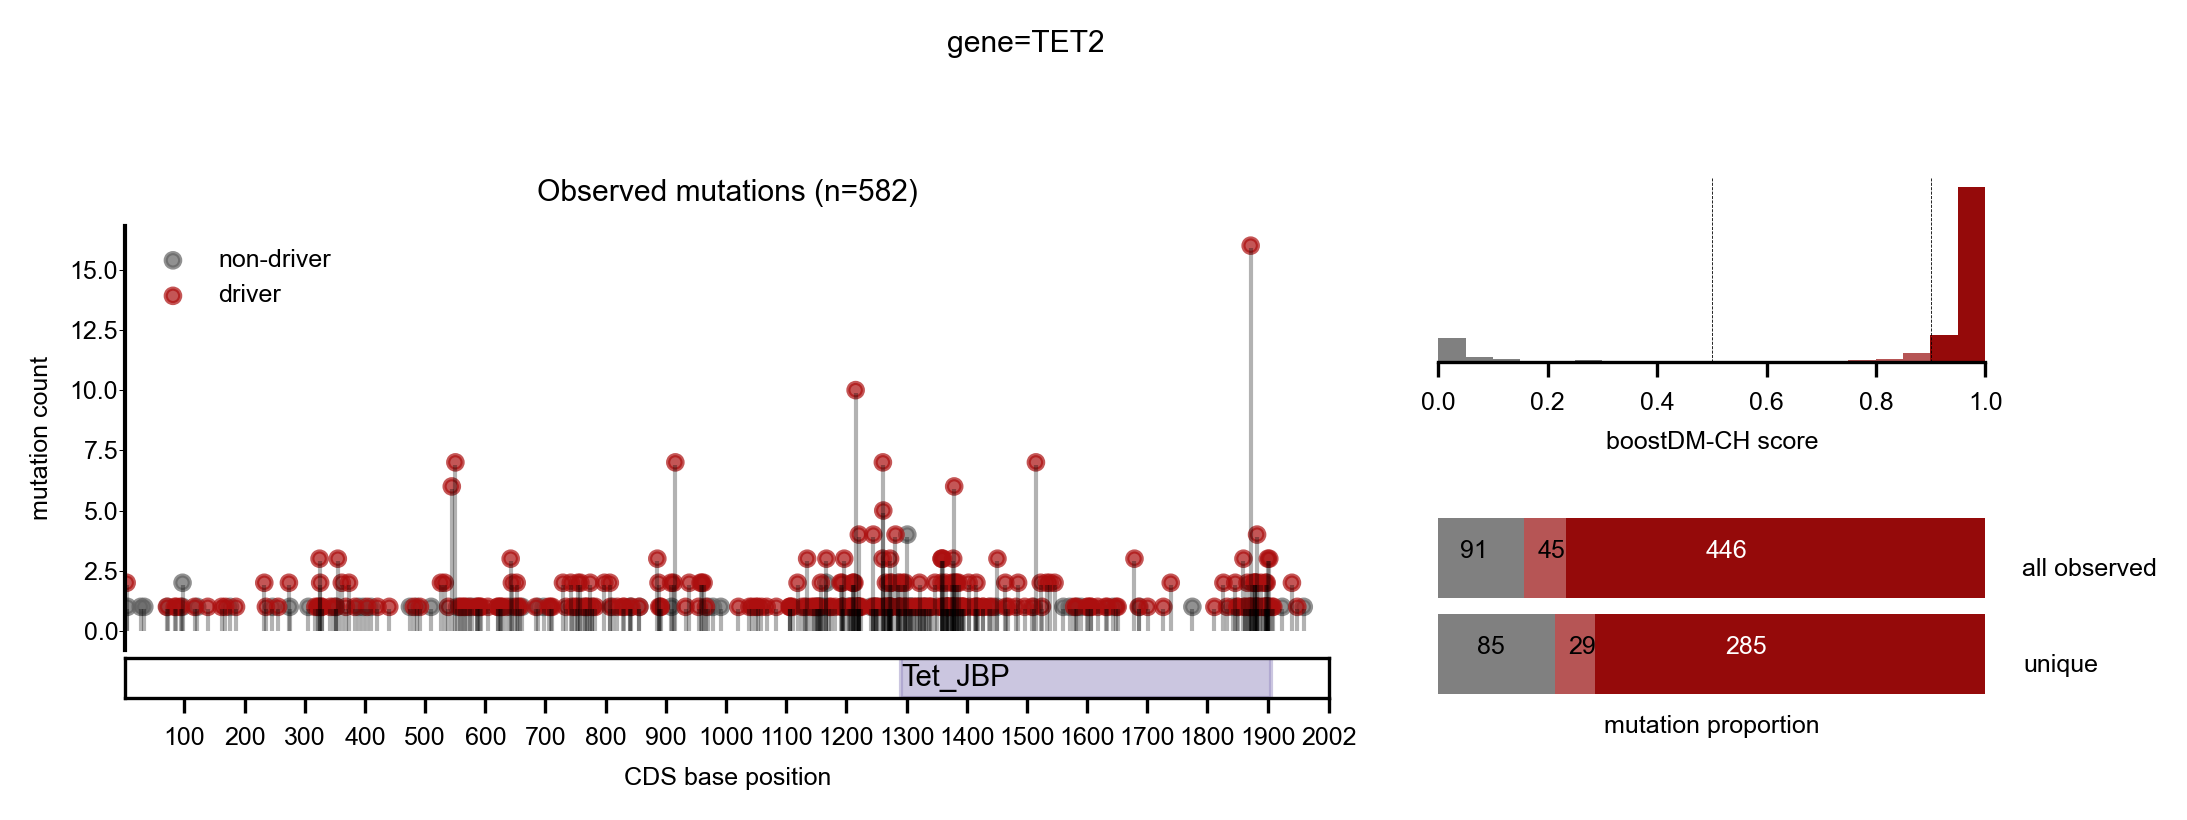

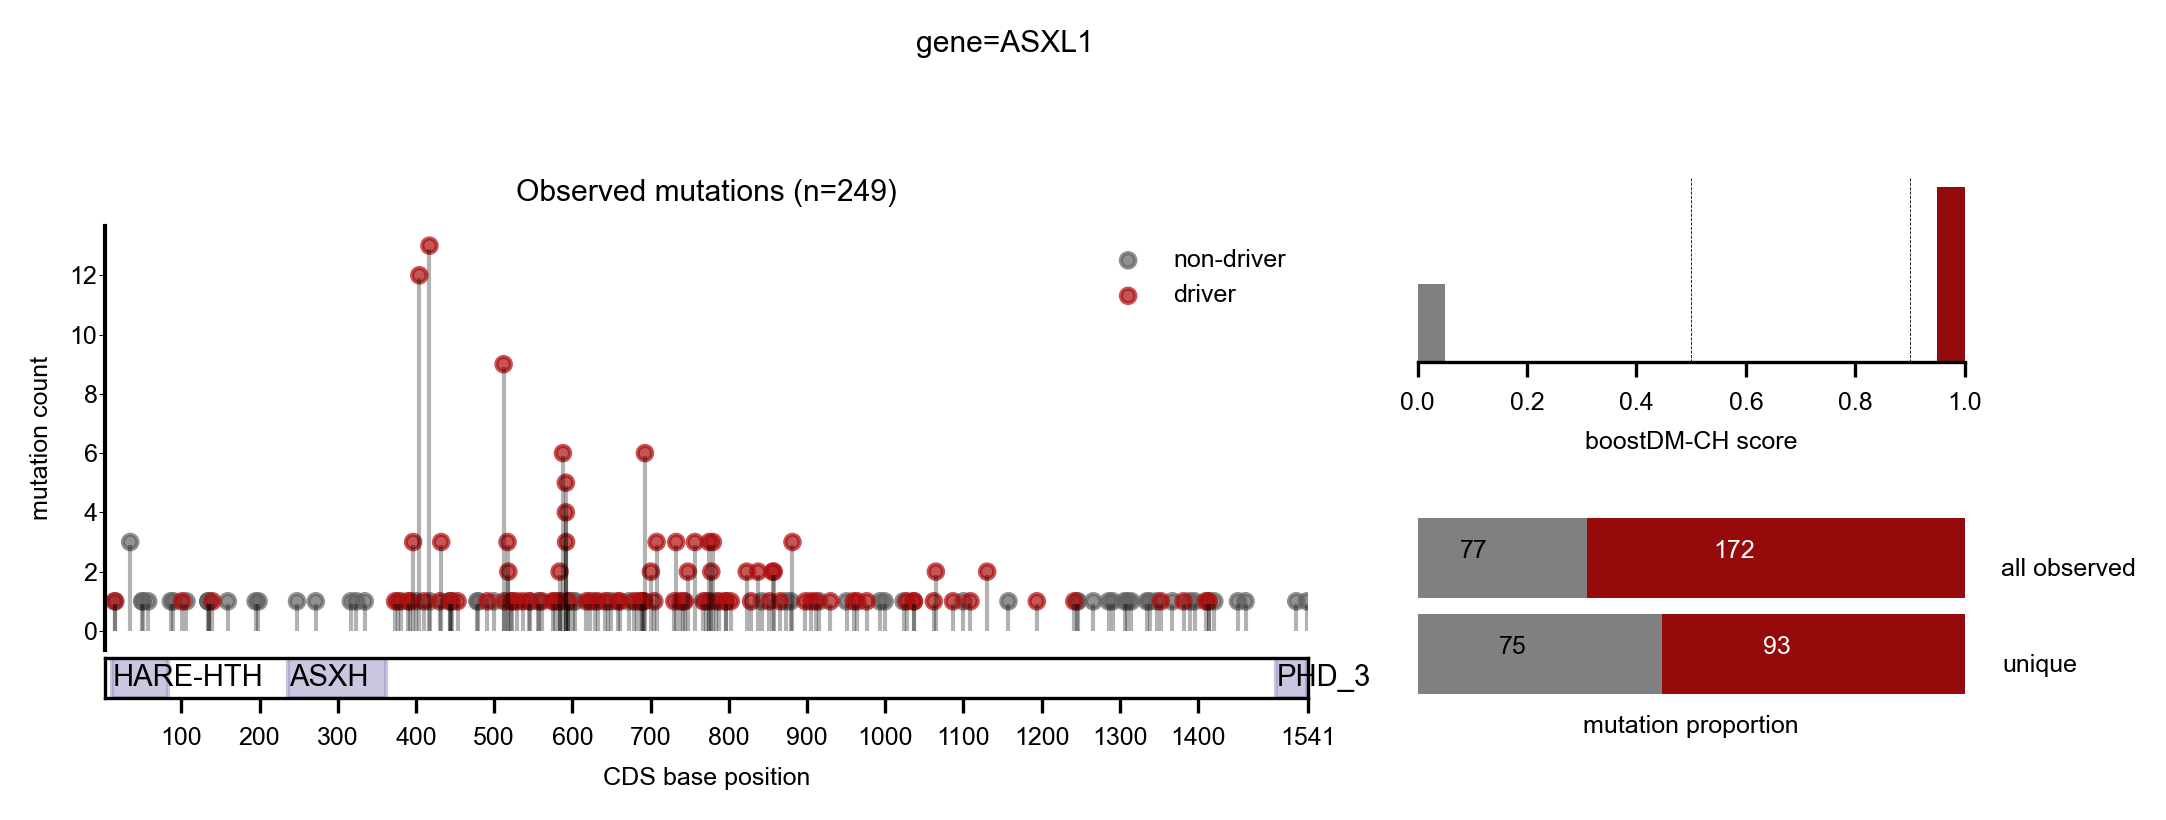

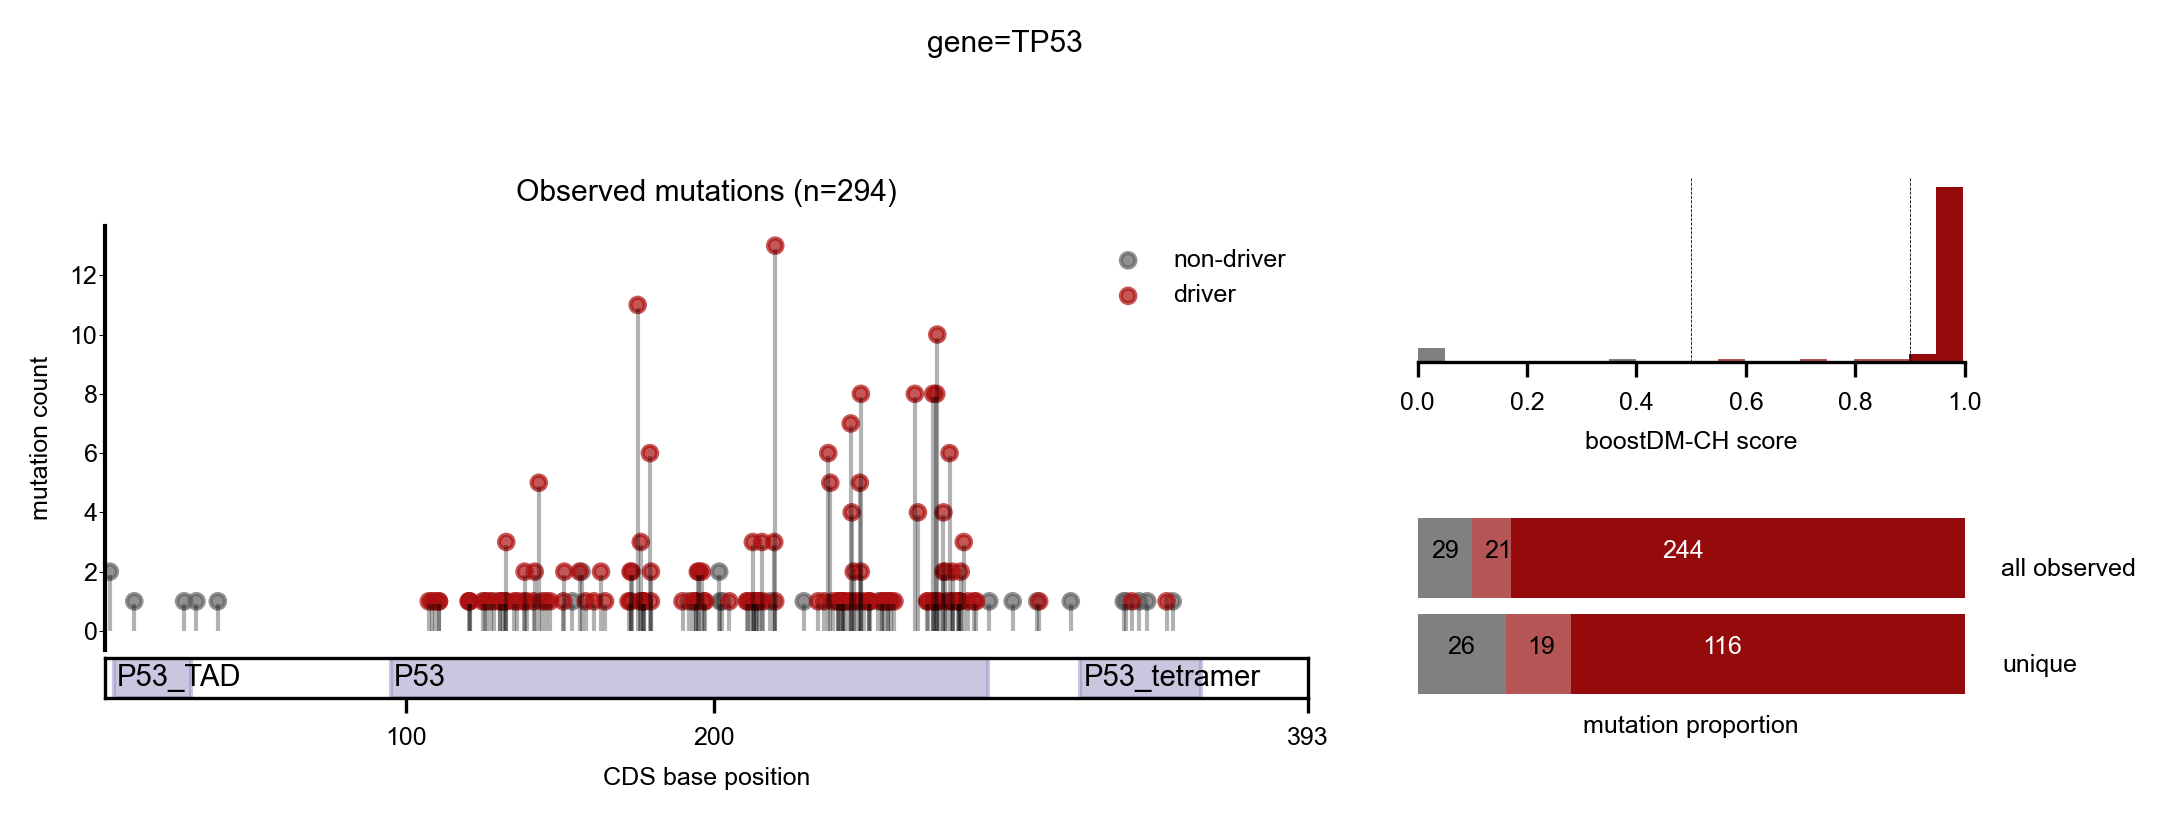

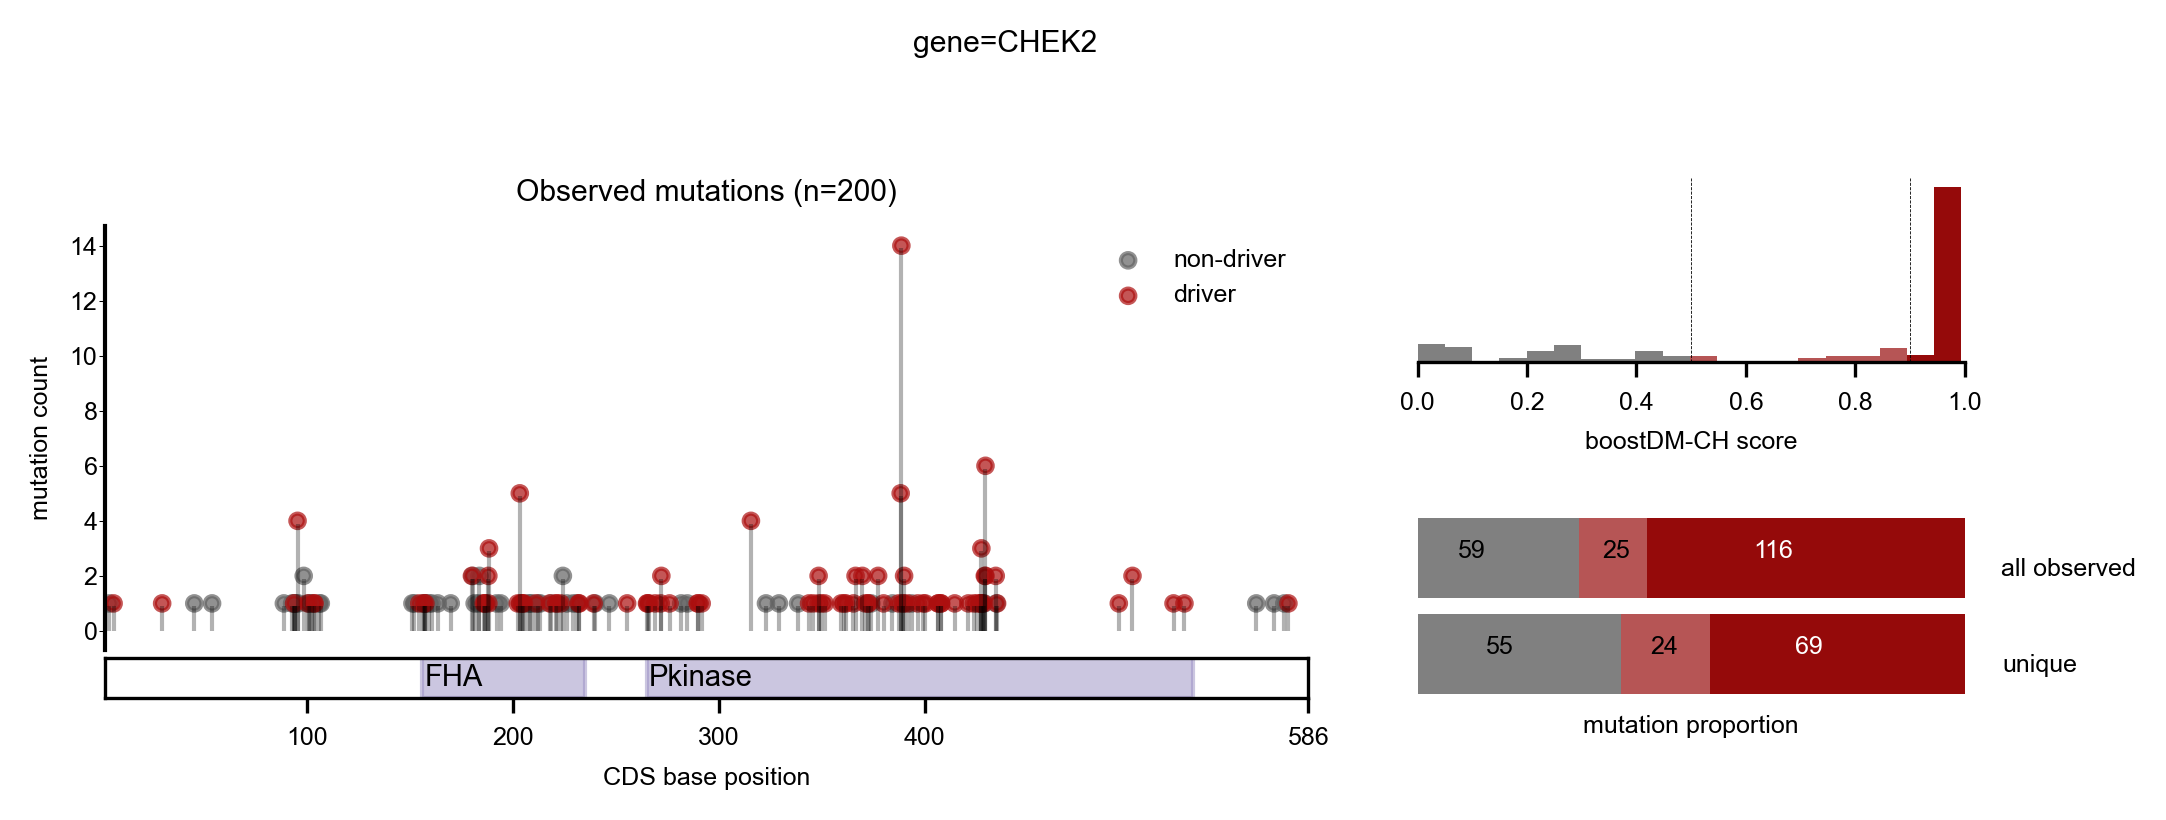

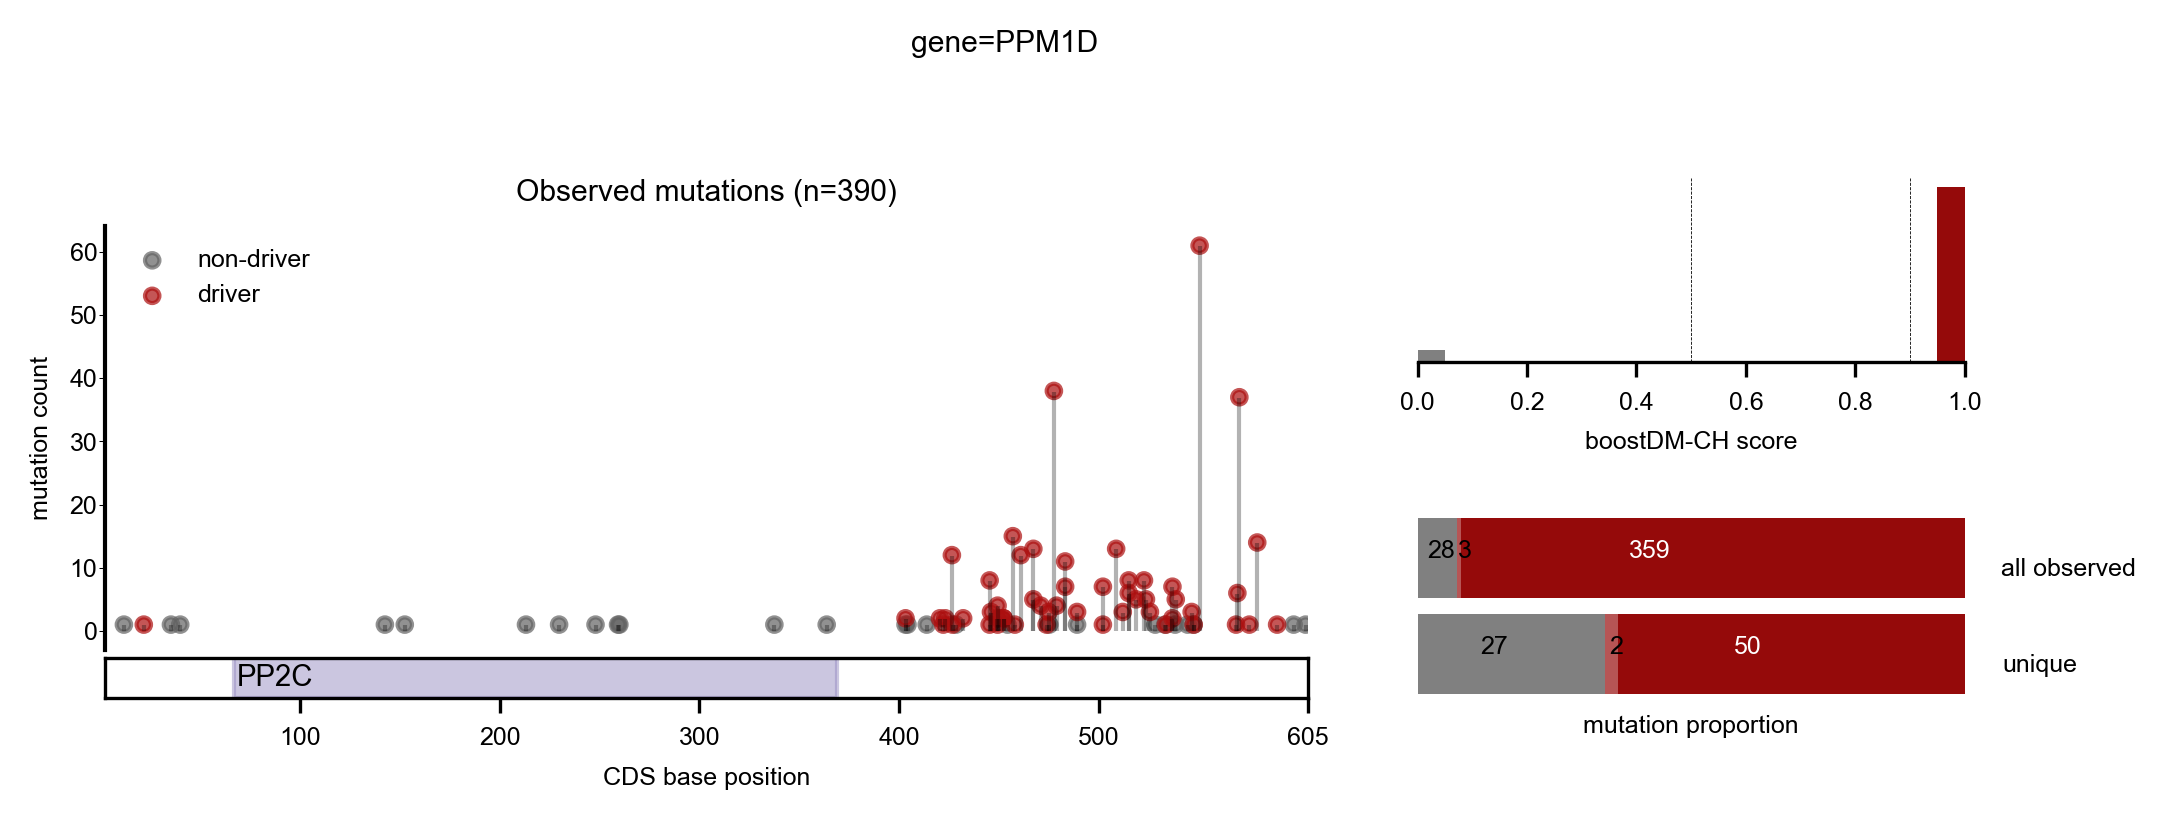

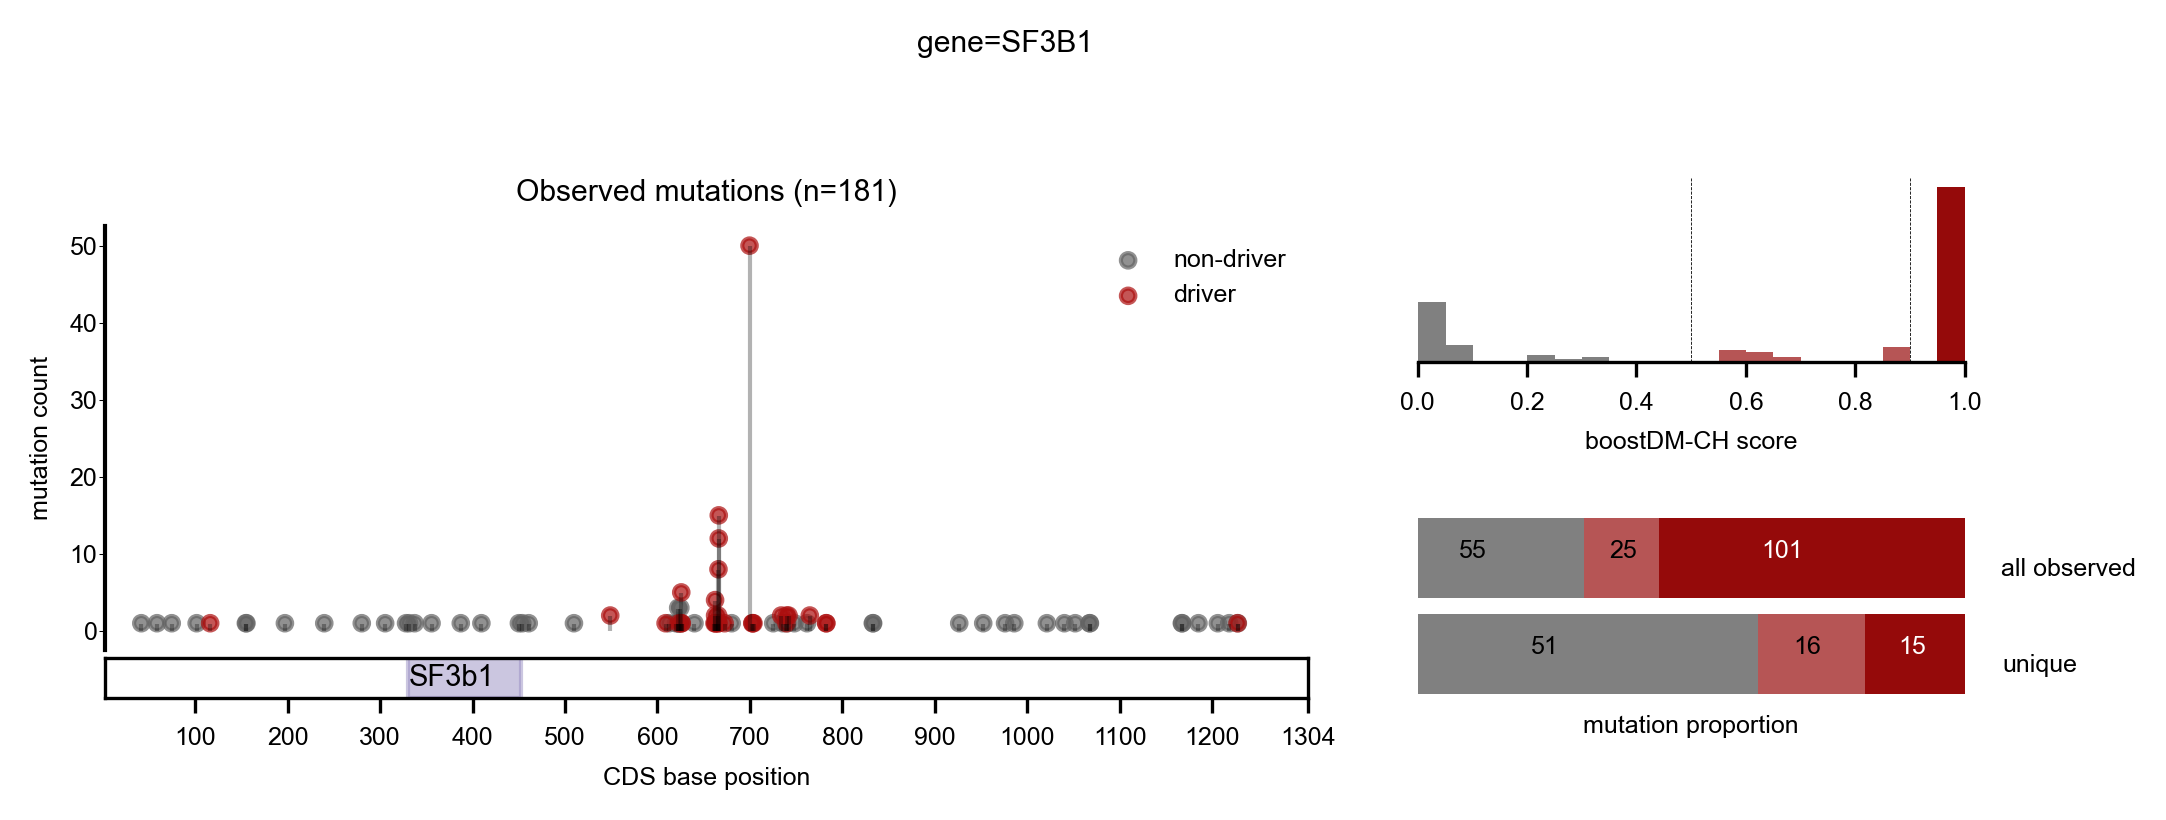

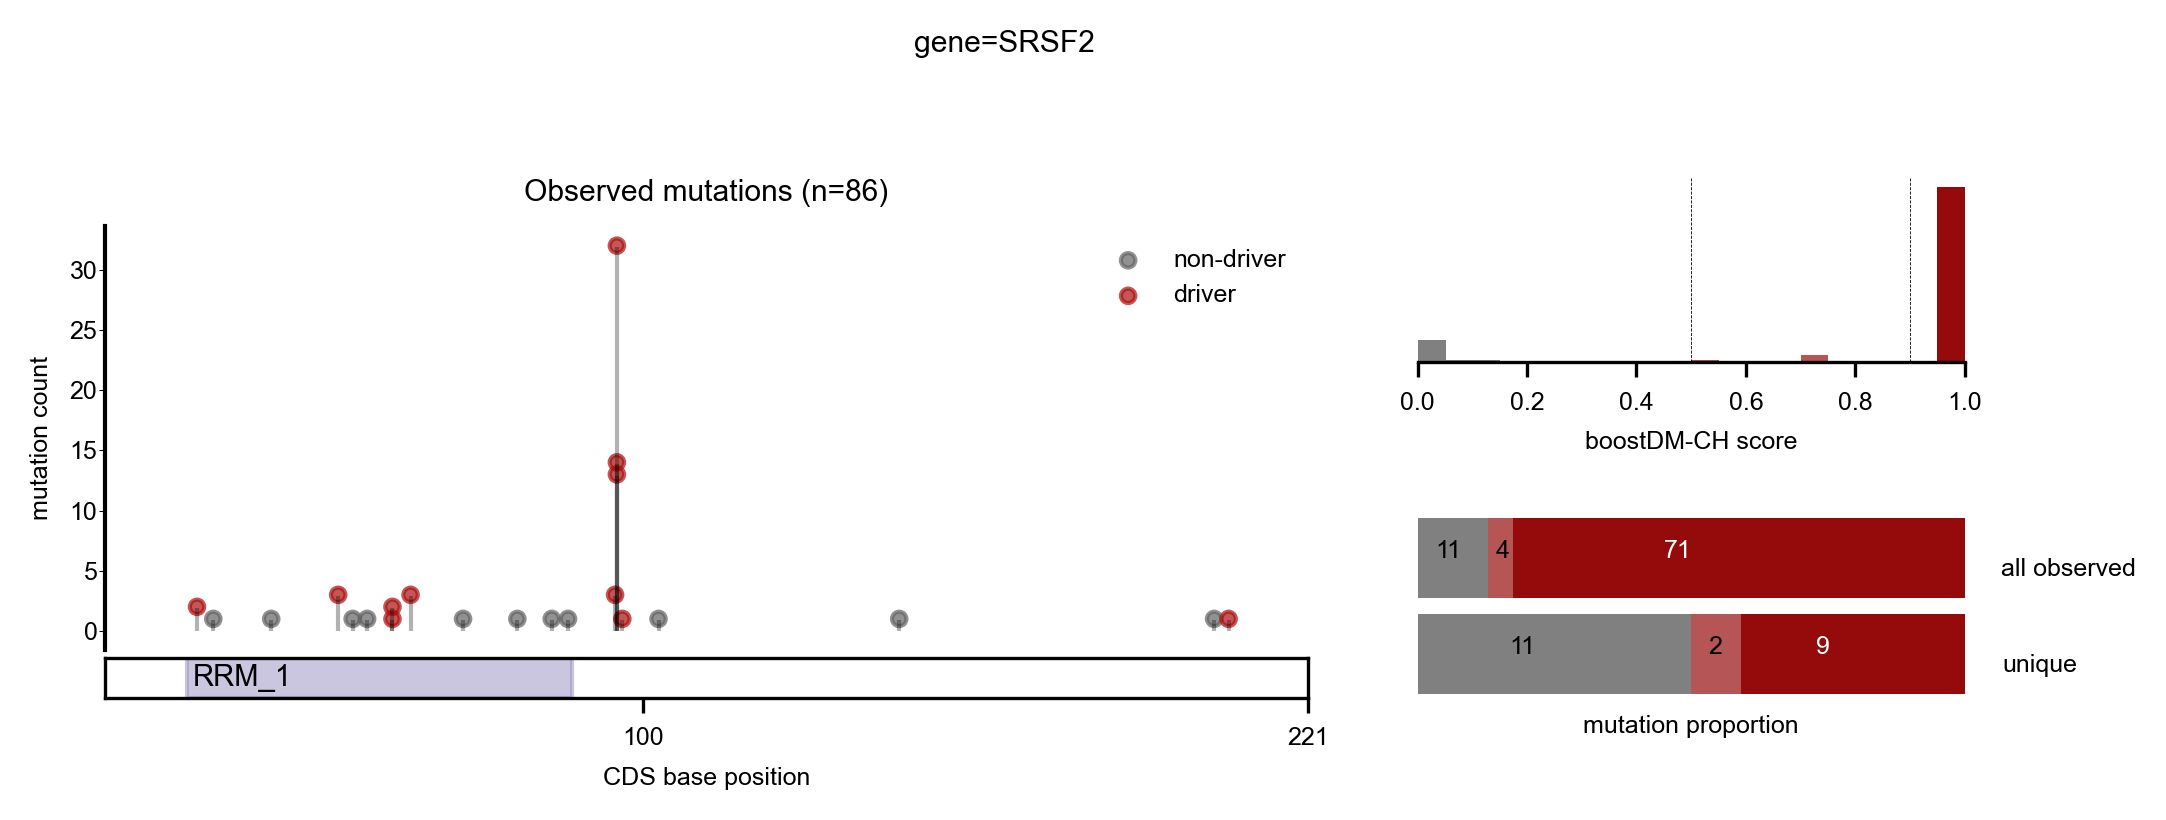

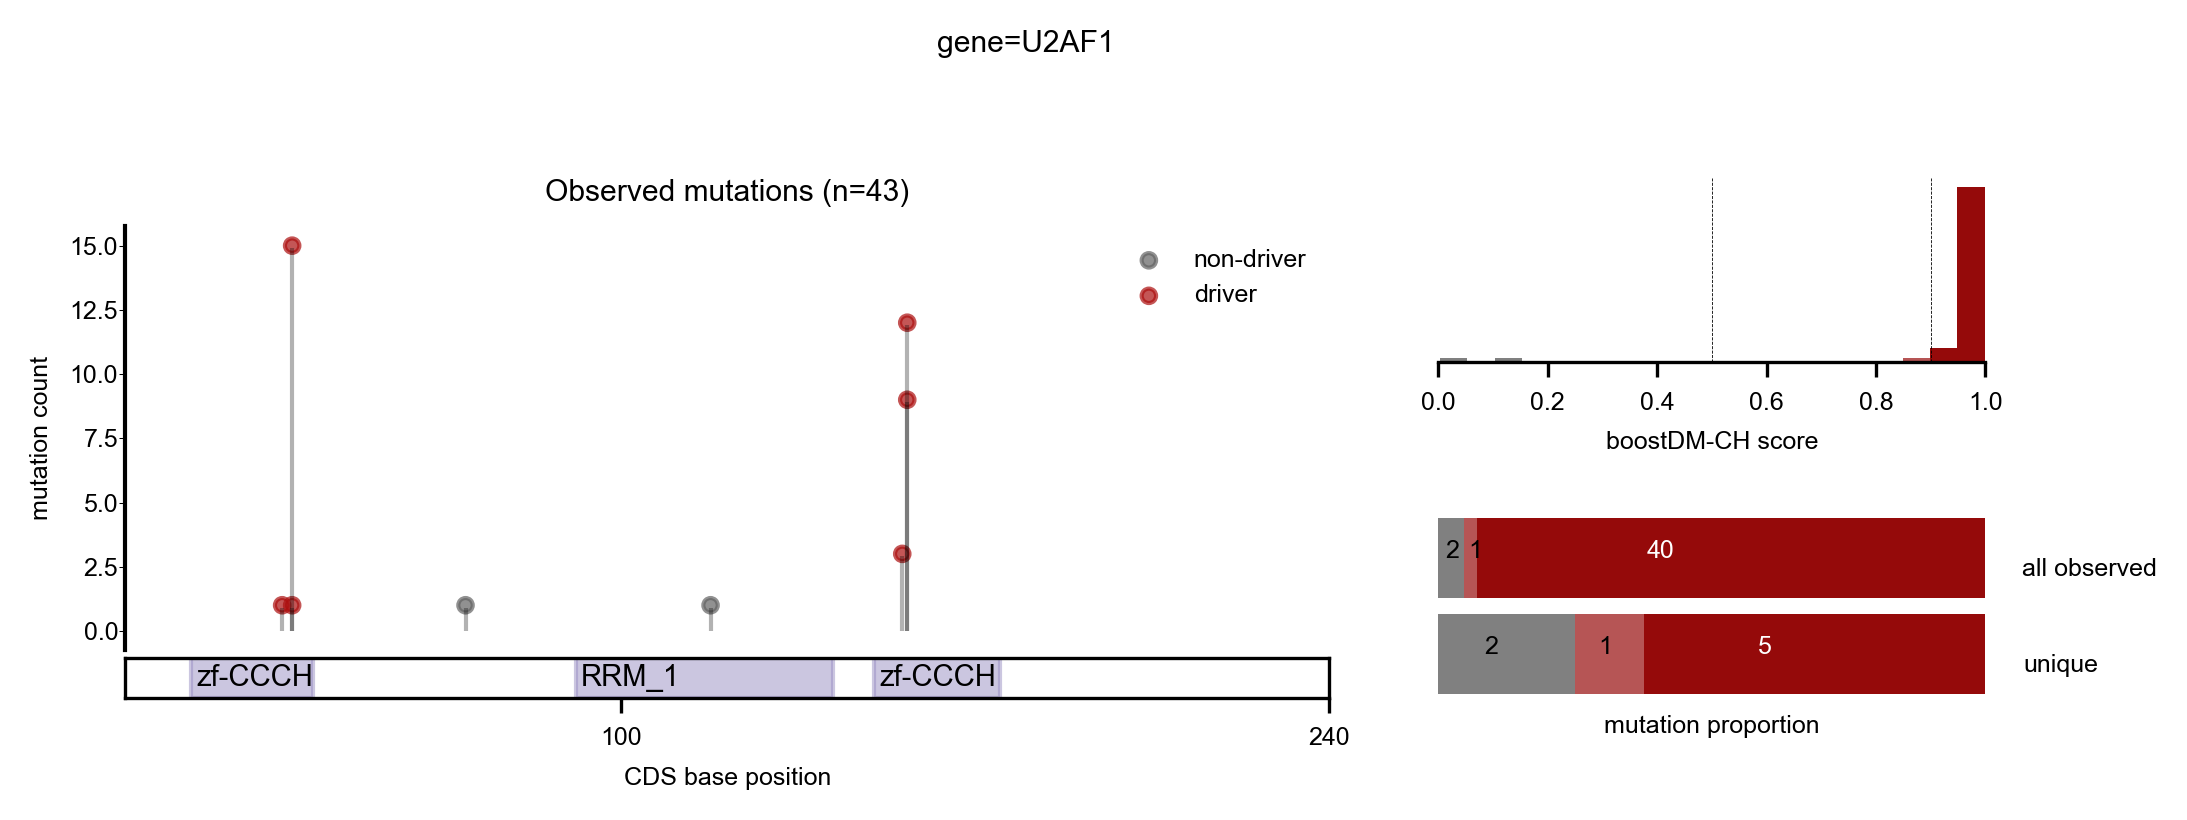

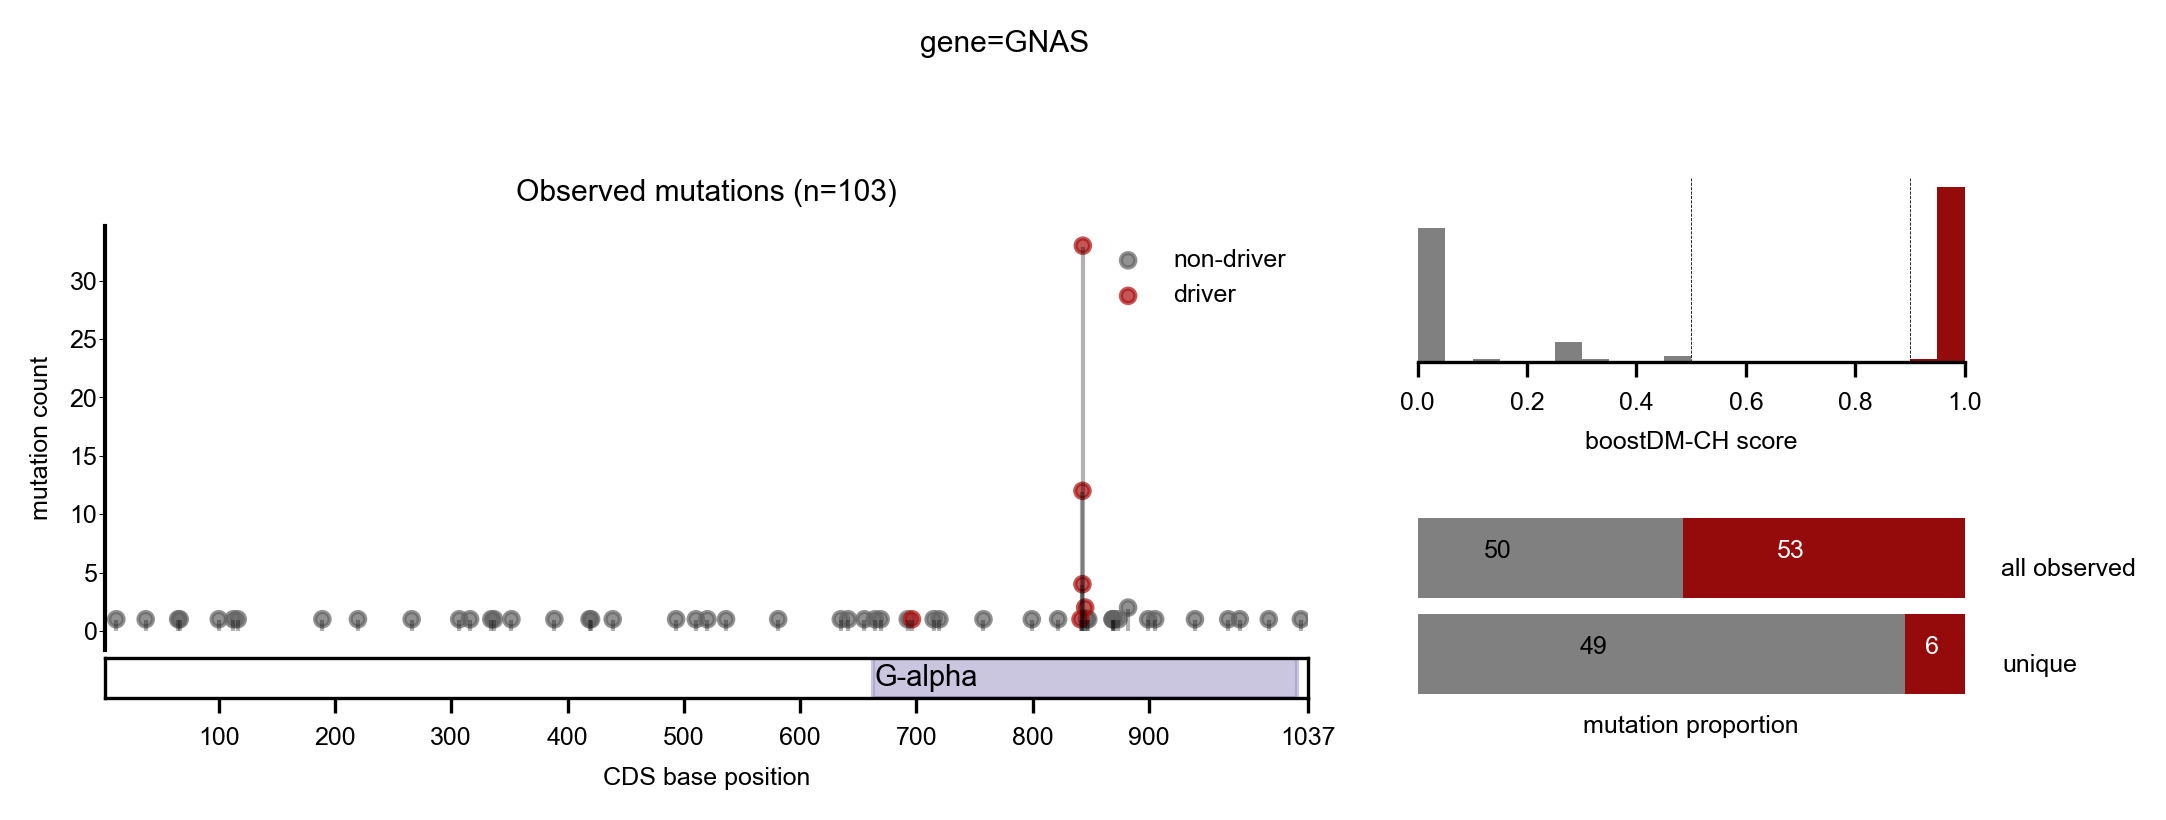

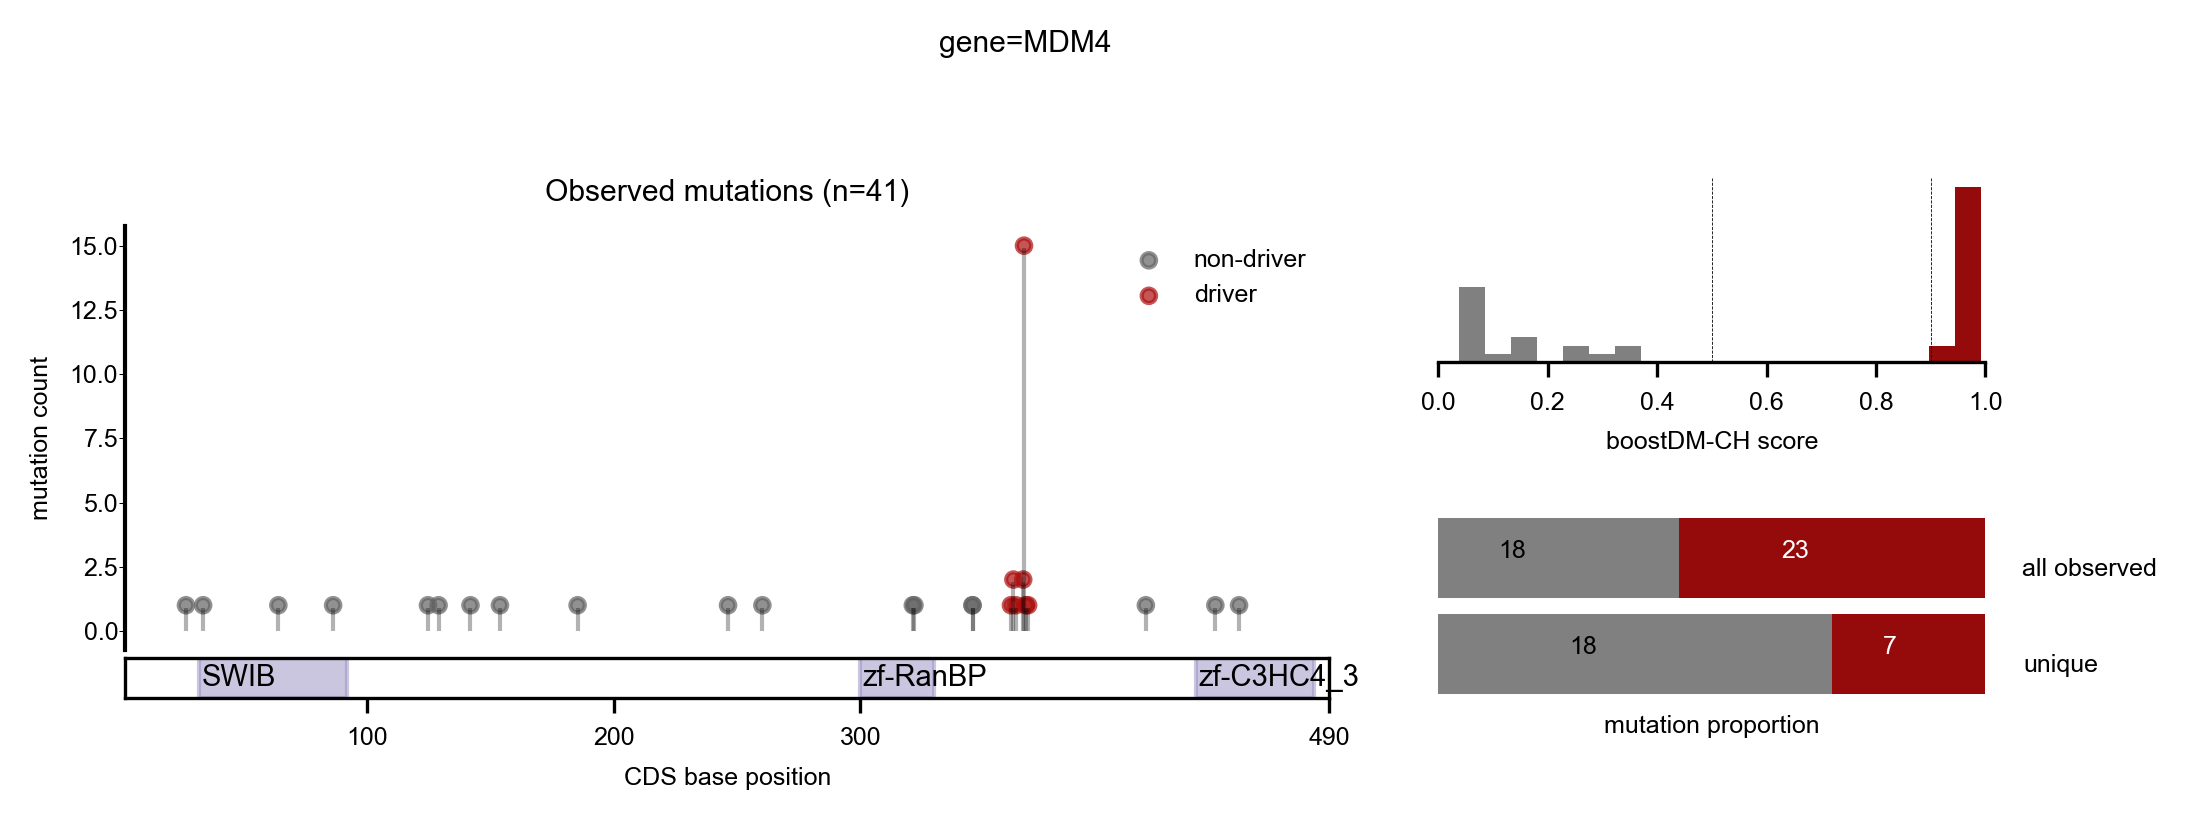

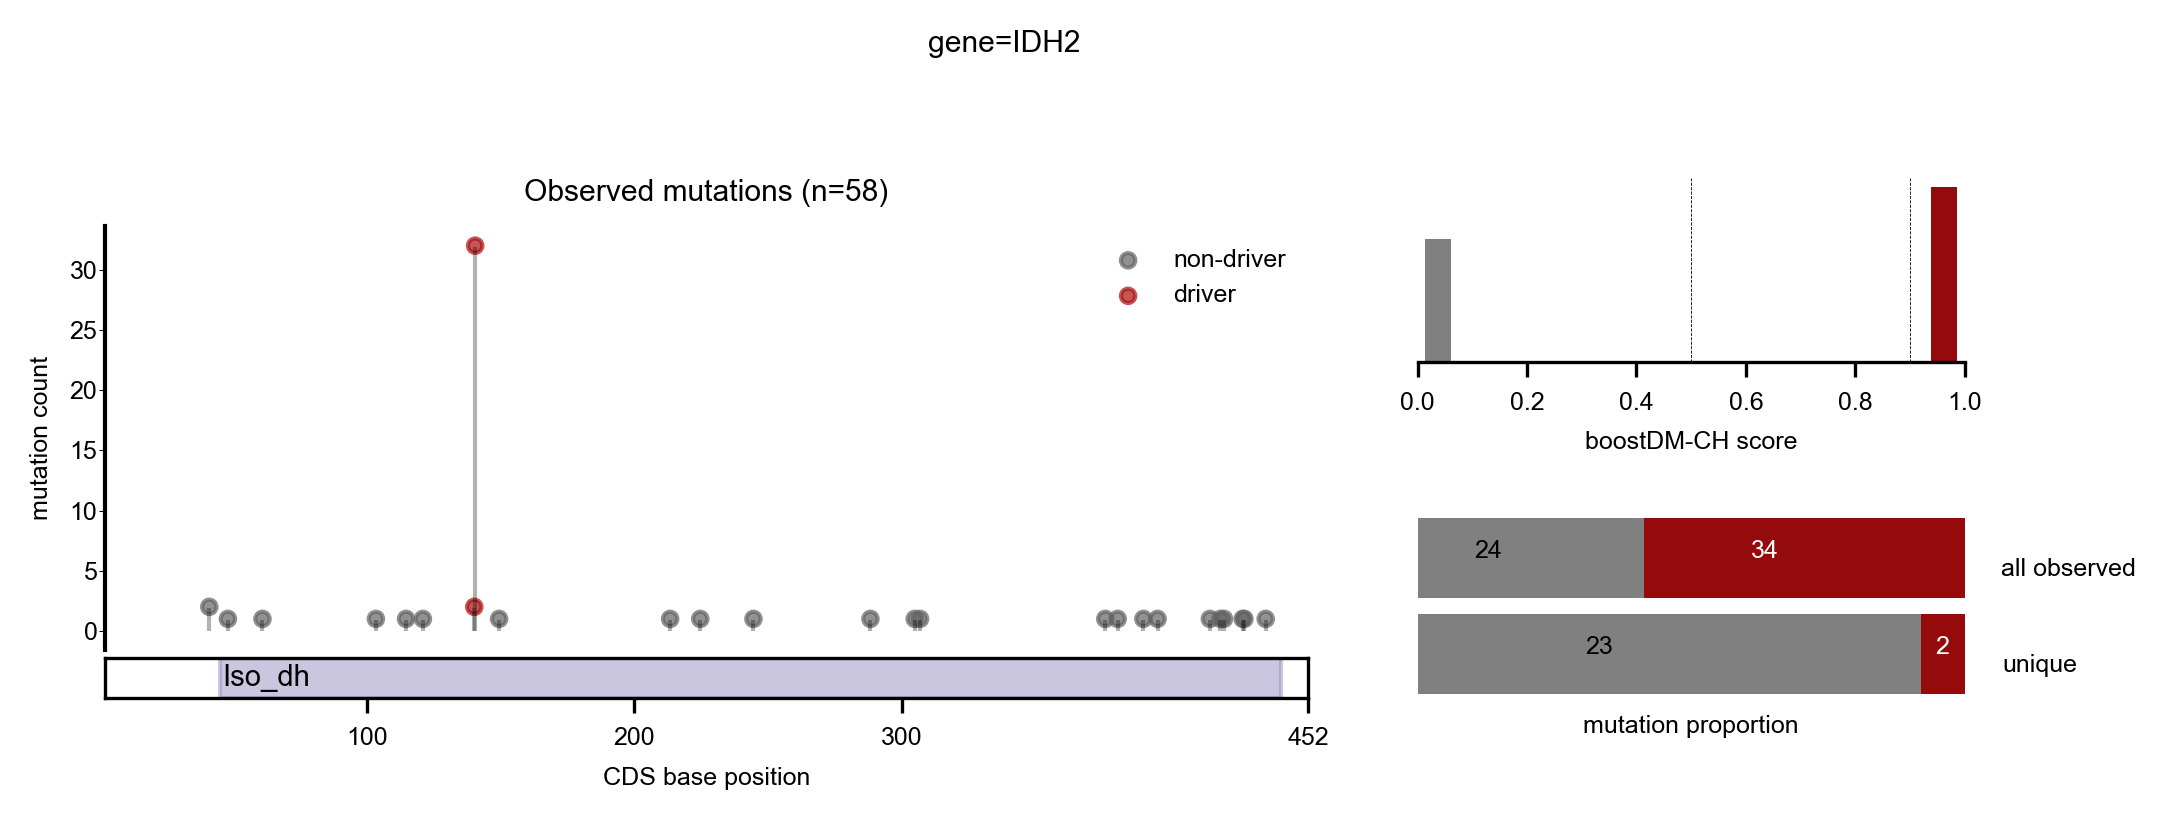

In [25]:
genes = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'CHEK2', 'PPM1D', 'SF3B1', 'SRSF2', 'U2AF1', 'GNAS', 'MDM4', 'IDH2']
for gene in genes:
    needleplot(gene)

### 3- Supplemental Figure S8B

Mutational profile of the observed SNV by cohort

In [27]:
# Select only the single nucleotide variants
obs_muts_SNV = obs_muts[obs_muts['impact']!='no-SNV']
obs_muts_SNV['ref'].value_counts()

G    191765
C    149940
A     42102
T     41753
Name: ref, dtype: int64

In [29]:
from itertools import product

CB = dict(zip(list('ACGT'), list('TGCA')))

def mut_key_generator():
    """
    Returns:
        Generates all possible lexicographic pairs
            1st component: substitution;
            2nd component: flanks
    """
    subs = ['CA', 'CG', 'CT', 'TA', 'TC', 'TG']
    for s in sorted(subs):
        for c in sorted(product({'A', 'C', 'G', 'T'}, repeat=2)):
            yield tuple([s, ''.join(c)])


def shortkey_to_lex(key):
    """
    Args:
        key: signature key in short key format
    Returns:
        tuple representing a lexicographic pair key
    """
    t1 = ''.join([key[1], key[-1]])
    t2 = ''.join([key[0], key[2]])
    return tuple([t1, t2])


def complementary(key):
    """
    Args:
        key: short key format
    Returns:
        DNA complementary in short key format
    """
    ref = key[1]
    alt = key[-1]
    ctxt = (key[0], key[2])
    return ''.join([CB[ctxt[1]], CB[ref], CB[ctxt[0]], '>', CB[alt]])

def mut_keys():
    """generator of signature channels in lexicographic order"""
    for change, context in mut_key_generator():
        yield context[0] + change[0] + context[1] + '>' + change[1]
    

class dNdSOut:

    def __init__(self, annotmuts_fn):

        self.annotmuts = annotmuts_fn.copy()

    @staticmethod
    def pyr_context(row):
        """pyr-context associated to row in maf table"""

        context = row['ref3_cod'] + '>' + row['mut_cod']
        if context[1] not in list('CT'):
            context = complementary(context)
        return context

    def catalogue(self):
        """96 channel count matrix"""
        
        # exclude mutations in any driver genes
#         df = self.annotmuts[~self.annotmuts['gene'].isin(genes12)].copy()
        
        # select SNVs
#         df = self.annotmuts[(self.annotmuts['ref'].isin(list('ACGT'))) & (self.annotmuts['alt'].isin(list('ACGT')))].copy()
        df = self.annotmuts.copy()
        
        # create context for each SNV
        df.loc[:, 'context'] = df.apply(self.pyr_context, axis=1)
        
        # count SNVs per context
        dg = df.groupby('context').agg('count')
#         catalogue = dg.loc[list(mut_keys()), 'sampleID'].tolist()
        catalo = []
        for x in list(mut_keys()):
            if x in dg.index.tolist():
                catalo.append(dg.loc[x,'sampleID'])
            else:
                catalo.append(0)
        
        return catalo
    

def minor_tick_labels():
    
    major_labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    flanks = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT',
              'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    minor_labels = []
    for subs in major_labels:
        for flank in flanks:
            minor_labels.append(flank[0] + subs[0] + flank[1])
    return minor_labels


def plot_profile(profile, title=None):

    fig, ax = plt.subplots(figsize=(15, 2))
    total = np.sum(profile)
    if abs(total - 1) > 0.01:
        profile = profile / total
    sns.set(font_scale=1.5)
    sns.set_style('white')

    # bar plot
    barlist = ax.bar(range(96), profile)
    color_list = ['#72bcd4', 'k', 'r', '#7e7e7e', 'g', '#e6add8']
    for category in range(6):
        for i in range(16):
            barlist[category * 16 + i].set_color(color_list[category])
    ax.set_xlim([-0.5, 96])
    ymax = np.max(profile) * 1.2
    ax.set_ylim(0, ymax)

    # ax.set_ylabel('subs rel freq')
    labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    major_ticks = np.arange(8, 8 + 16 * 5 + 1, 16)
    minor_ticks = np.arange(0.2, 96.2, 1)
    ax.tick_params(length=0, which='major', pad=30, labelsize=12)
    ax.tick_params(length=0, which='minor', pad=5, labelsize=10)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels(labels, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(minor_tick_labels(), minor=True, rotation=90)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title+f'; n={total:,}', fontsize=24)
    plt.show()

In [31]:
# separate the mutations in different cohorts
obs_muts_tcg = obs_muts_SNV[obs_muts_SNV['COHORT']=='OTHER_WXS_TCGA_FULL']
print(len(obs_muts_tcg))
obs_muts_HMF = obs_muts_SNV[obs_muts_SNV['COHORT']=='OTHER_WGS_HMF_FULL']
print(len(obs_muts_HMF))
obs_muts_impact = obs_muts_SNV[obs_muts_SNV['COHORT']=='OTHER_WXS_CH_IMPACT_PANEL']
print(len(obs_muts_impact))

383352
33025
9183


In [32]:
catalogue_dict = {}
for label, fn in zip(['all_observed','tcga_all_observed', 'hartwig_all_observed', 'MSK-IMPACT'],
                     [obs_muts_SNV, obs_muts_tcg, obs_muts_HMF, obs_muts_impact]):
    dndscv = dNdSOut(fn)
    catalogue = dndscv.catalogue()
    catalogue_dict[label] = catalogue

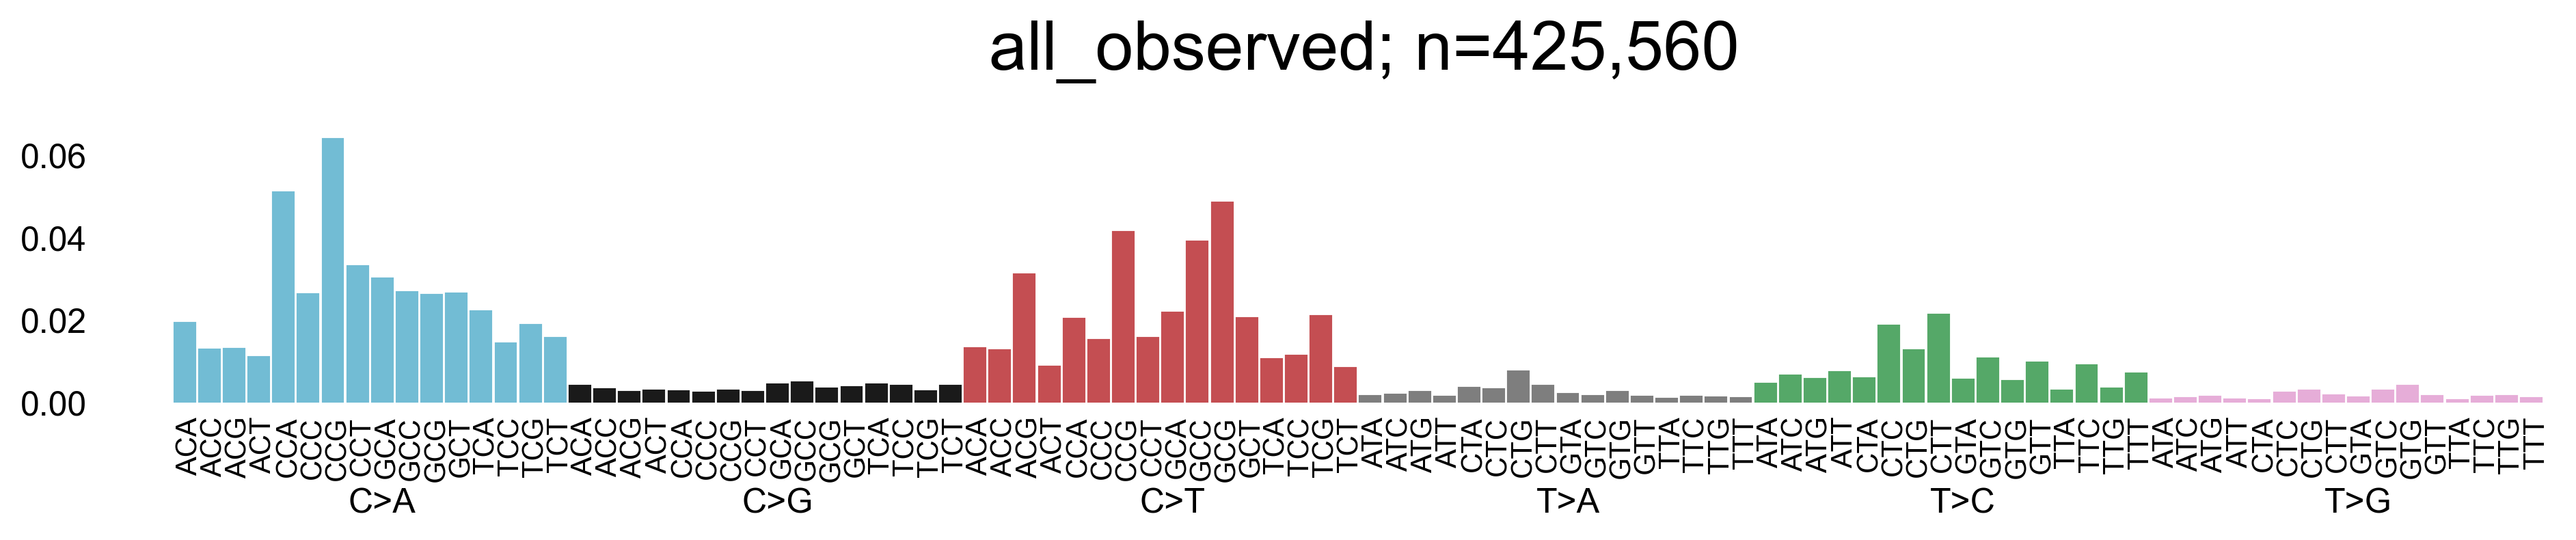

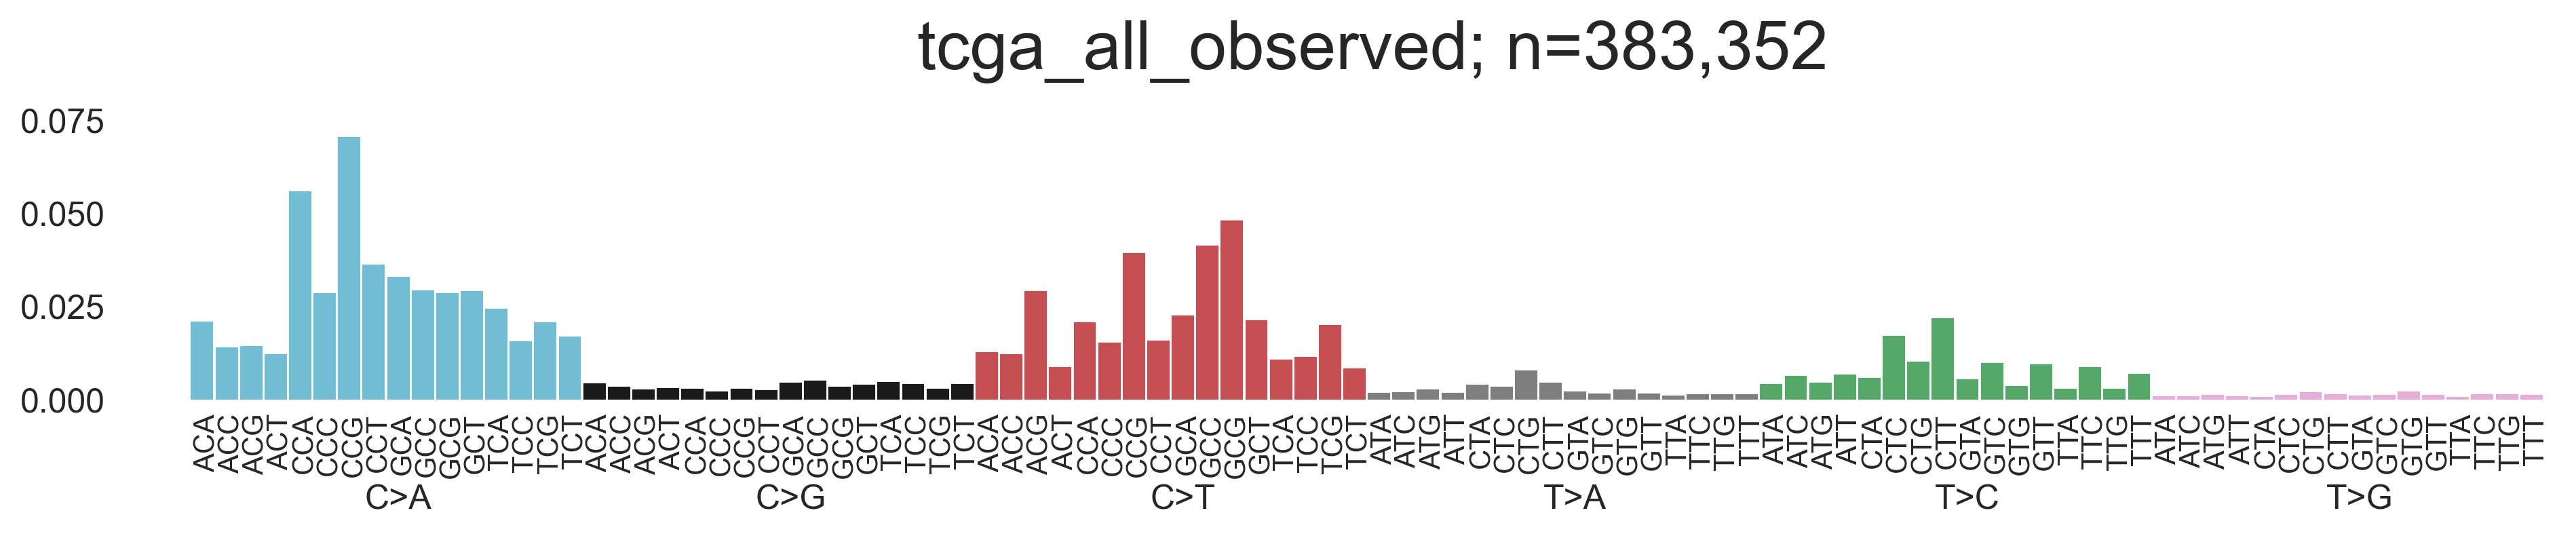

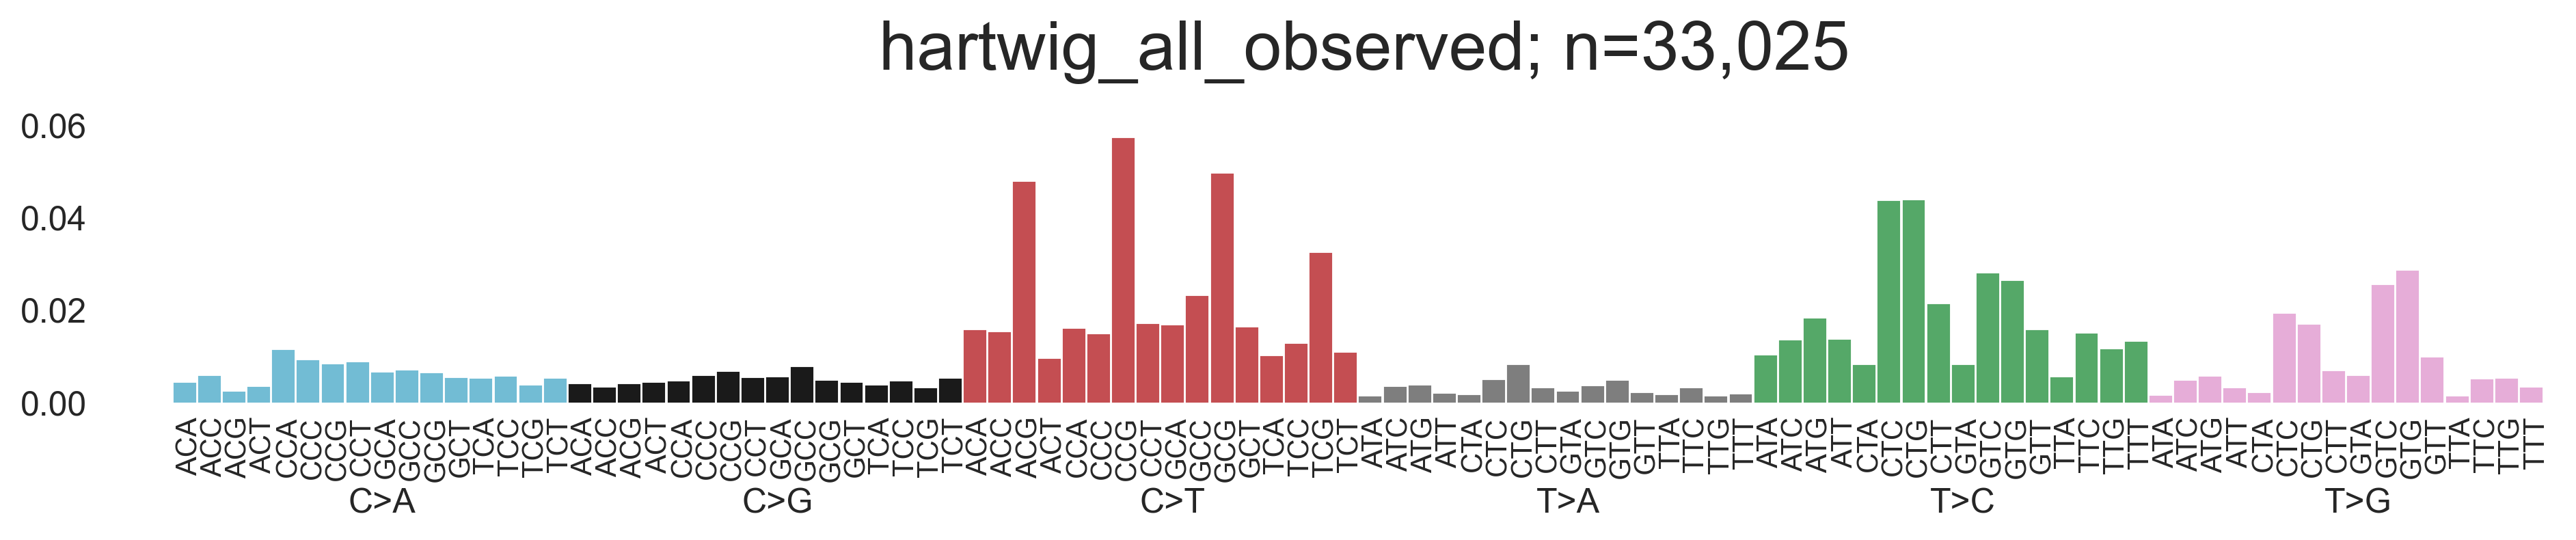

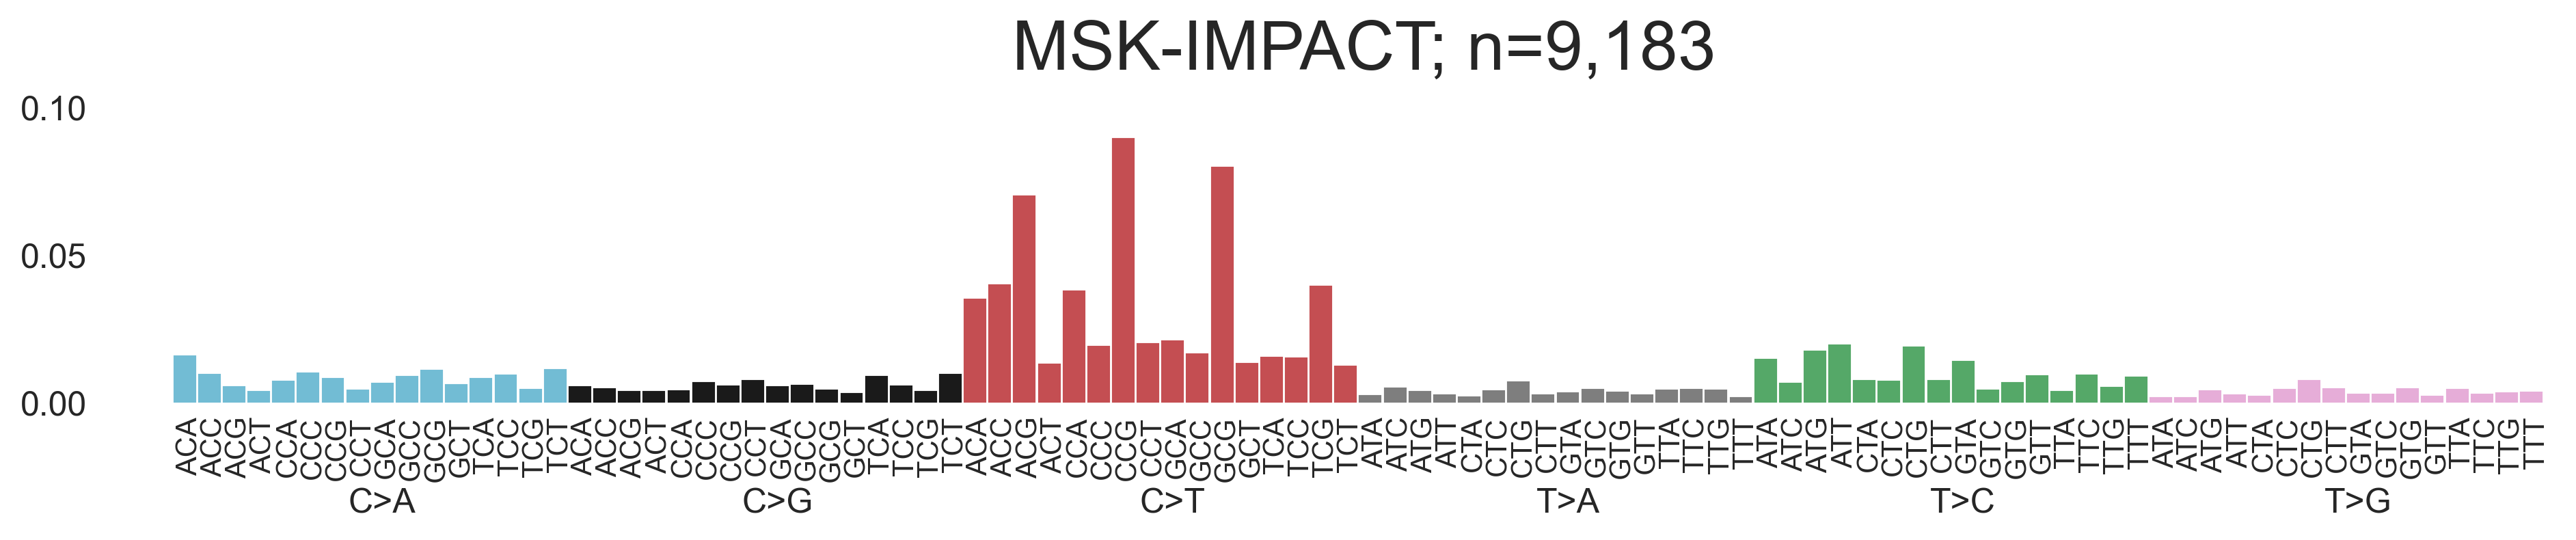

In [33]:
for cohort, profile in catalogue_dict.items():
    plot_profile(profile, title=cohort)